In [1]:
# 引入原始数据和依赖包
import shutil
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from autogluon.core.utils.loaders import load_pd
from sklearn.model_selection import train_test_split
from autogluon.multimodal import MultiModalPredictor
from sklearn.manifold import TSNE
from autogluon.tabular import TabularPredictor
import pandas as pd
import uuid
from sklearn.model_selection import train_test_split
import os
from nltk import bigrams
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def delete_dir(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)

warnings.filterwarnings('ignore')
np.random.seed(123)

dataset_origin = load_pd.load('./dataSet.csv')

model_list = ['LightGBMLarge', 'LightGBMXT', 'XGBoost', 'LightGBM', 'CatBoost', 'KNeighborsDist', 'KNeighborsUnif','RandomForestEntr', 'RandomForestGini', 'ExtraTreesEntr', 'ExtraTreesGini']

model_list_output = ['onlyNLP', 'LightGBMLarge', 'LightGBMXT', 'XGBoost', 'LightGBM', 'CatBoost', 'KNeighborsDist', 'KNeighborsUnif','RandomForestEntr', 'RandomForestGini', 'ExtraTreesEntr', 'ExtraTreesGini']

result_pd_origin = pd.DataFrame(np.zeros((len(model_list_output),8)))
result_pd_origin.index = model_list_output
result_pd_origin.columns = ['ValAcc','ValPre','ValRec','ValF1','TestAcc','TestPre','TestRec','TestF1']

In [2]:
# 绘制混淆矩阵函数定义
def plot_confusion_matrix(cm, title='', cmap=plt.cm.get_cmap('rainbow'), labels=[], filename=None):
    mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    })  # 设置全局字体
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    plt.rcParams['figure.max_open_warning'] = 1000  # 用来正常显示负号
    plt.rc('font', family='Arial', size='6')  # 设置字体样式、大小
    fonten = {'family': 'Arial', 'size': 6}
    fonten_small = {'family': 'Arial', 'size': 5}


    fig, ax = plt.subplots()
    fig.set_facecolor('white')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带
    ax.set_xlabel('Second AA',fontdict=fonten)
    ax.set_ylabel('First AA',fontdict=fonten)
    ax.set_title(title,fontdict=fonten)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels)


    # 通过绘制格网，模拟每个单元格的边框
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 标注百分比信息
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(int(cm[i, j])),fontdict=fonten_small,
                            ha="center", va="center",
                            color="black" )
    fig.tight_layout()
    plt.savefig(filename+'.pdf', dpi=300,bbox_inches='tight')
    plt.savefig(filename+'.png', dpi=300,bbox_inches='tight')

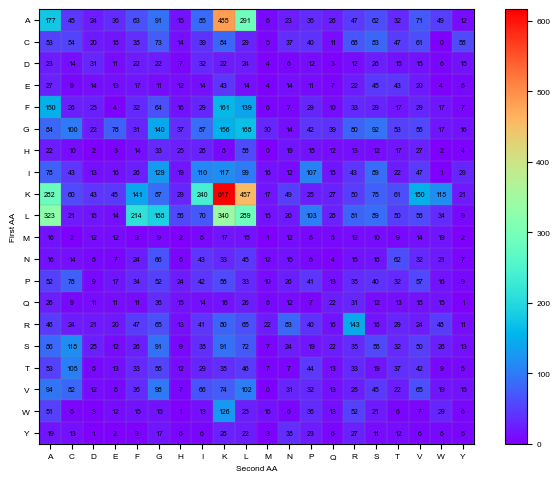

In [16]:
# 生成词频矩阵
if not os.path.exists(os.path.join('outputFigure','aaMatrix')):
    os.makedirs(os.path.join('outputFigure','aaMatrix'))
dataset_origin_anti = dataset_origin[dataset_origin.Label==1].copy()
document = dataset_origin_anti.Value.apply(lambda x:list(x)).tolist()
new_list = list()
for x in document:
    new_list = new_list + x
new_list = list(np.array(new_list))
names = list(np.unique(new_list))
word_matrix = np.zeros((len(names), len(names)))
bgrms = list(bigrams(new_list))
bgrm_counter = Counter(bgrms)
for x in range(len(names)):
    for y in range(len(names)):
        counter_num = bgrm_counter.get(tuple([names[x], names[y]]))
        if counter_num is None:
            word_matrix[x,y] = 0
        else:
            word_matrix[x,y] = counter_num
plot_confusion_matrix(word_matrix,labels=names,filename=os.path.join('outputFigure','aaMatrix','aaMatrix'))
file = open(os.path.join('outputFigure','aaMatrix','aaMatrixMostCountTop20.txt'), "w")
for item in bgrm_counter.most_common(20):
    file.write(str(item) + "\n")
file.close()

aa_counter = Counter(new_list)
file = open(os.path.join('outputFigure','aaMatrix','aaMostCount.txt'), "w")
for item in aa_counter.most_common(22):
    file.write(str(item) + "\n")
file.close()


In [3]:
def plot_roc(y_test,y_score,save_name,title=''):
    # 计算
    fpr, tpr, thread = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    # 绘图
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ' + title)
    plt.legend(loc="lower right")
    plt.savefig(save_name+'.pdf', dpi=300,bbox_inches='tight')
    plt.savefig(save_name+'.png', dpi=300,bbox_inches='tight')
    plt.show()

In [5]:
def access_dataset(dataset:pd.DataFrame,save_path,use_nlp=True):
    # 定义返回数组，依次为：
    # 深度学习验证集bert-base-uncased网络原始准确率，深度学习测试集bert-base-uncased网络原始准确率，
    # 机器学习验证集bert-base-uncased网络准确率，机器学习测试集bert-base-uncased网络准确率，
    # 深度学习验证集m3e-base网络原始准确率，深度学习测试集m3e-base网络原始准确率，
    # 机器学习验证集m3e-base网络准确率，机器学习测试集m3e-base网络准确率，
    # 机器学习验证集原始编码准确率，机器学习测试集原始编码准确率
    result_array = np.zeros((10,))
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=1234)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=1234)
    if use_nlp:
        # bert-base-uncased模型，最后选用3个最高的模型greedy soup集成
        print(save_path,' ','bert-base-uncased')
        file_savepath_origin = os.path.join('outputFigure', save_path, 'bert_base_uncased')
        file_savepath = os.path.join('outputFigure', save_path, 'bert_base_uncased')
        model_path = os.path.join(file_savepath_origin,'model','nlp')
        if not os.path.exists(file_savepath):
            os.makedirs(file_savepath)
        if os.path.exists(model_path):
            delete_dir(model_path)
        pd_result = result_pd_origin.copy()
        predictor = MultiModalPredictor(label='Label', eval_metric='acc', path=model_path,hyperparameters={"model.hf_text.checkpoint_name": "./bert-base-uncased/"})
        predictor.fit(train_data = train_data,tuning_data = val_data)
        result_array[0] = predictor.evaluate(val_data)['acc']
        result_array[1] = predictor.evaluate(test_data)['acc']
        plt.figure()
        embeddings = predictor.extract_embedding(test_data)
        X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
        for val, color in [(0, 'red'), (1, 'blue')]:
            idx = (test_data['Label'].to_numpy() == val).nonzero()
            plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
        plt.legend(loc='best')

        filename = os.path.join(file_savepath,'tsne')
        plt.savefig(filename+'.pdf', dpi=300,bbox_inches='tight')
        plt.savefig(filename+'.png', dpi=300,bbox_inches='tight')
        plt.show()


        file_savepath = os.path.join('outputFigure', save_path, 'bert_base_uncased', 'onlyNLP')
        if not os.path.exists(file_savepath):
            os.makedirs(file_savepath)
        y_true = val_data.Label.to_numpy()
        y_pred = predictor.predict(val_data,as_pandas=False)
        y_pred_org = predictor.predict_proba(val_data,as_pandas=False, as_multiclass=False)
        filename = os.path.join(file_savepath,'val_roc')
        plot_roc(y_true,y_pred_org,filename,'bert_base_uncased onlyNLP ValSet')
        pd_result.loc['onlyNLP','ValAcc'] = accuracy_score(y_true, y_pred)
        pd_result.loc['onlyNLP','ValPre'] = precision_score(y_true, y_pred)
        pd_result.loc['onlyNLP','ValRec'] = recall_score(y_true, y_pred)
        pd_result.loc['onlyNLP','ValF1'] = f1_score(y_true, y_pred)

        y_true = test_data.Label.to_numpy()
        y_pred = predictor.predict(test_data,as_pandas=False)
        y_pred_org = predictor.predict_proba(test_data,as_pandas=False, as_multiclass=False)
        filename = os.path.join(file_savepath,'test_roc')
        plot_roc(y_true,y_pred_org,filename,'bert_base_uncased onlyNLP TestSet')
        pd_result.loc['onlyNLP','TestAcc'] = accuracy_score(y_true, y_pred)
        pd_result.loc['onlyNLP','TestPre'] = precision_score(y_true, y_pred)
        pd_result.loc['onlyNLP','TestRec'] = recall_score(y_true, y_pred)
        pd_result.loc['onlyNLP','TestF1'] = f1_score(y_true, y_pred)


        # 开始试验机器学习数据
        train_data_ml = pd.DataFrame(np.hstack([predictor.extract_embedding(train_data), np.expand_dims(np.squeeze(train_data.Label.to_numpy(copy=True)), -1)]))
        val_data_ml = pd.DataFrame(np.hstack([predictor.extract_embedding(val_data), np.expand_dims(np.squeeze(val_data.Label.to_numpy(copy=True)), -1)]))
        test_data_ml = pd.DataFrame(np.hstack([predictor.extract_embedding(test_data), np.expand_dims(np.squeeze(test_data.Label.to_numpy(copy=True)), -1)]))
        model_path = os.path.join(file_savepath_origin,'model','ml')
        if os.path.exists(model_path):
            delete_dir(model_path)
        predictor = TabularPredictor(path=model_path,label=train_data_ml.shape[1]-1).fit(train_data = train_data_ml,tuning_data = val_data_ml,fit_weighted_ensemble=False,excluded_model_types=['NN_TORCH', 'FASTAI'])
        result_array[2] = predictor.evaluate(val_data_ml)['accuracy']
        result_array[3] = predictor.evaluate(test_data_ml)['accuracy']
        predictor.leaderboard(test_data_ml)

        for modelname in model_list:
            file_savepath = os.path.join('outputFigure', save_path, 'bert_base_uncased', modelname)
            if not os.path.exists(file_savepath):
                os.makedirs(file_savepath)

            y_true = val_data_ml[val_data_ml.shape[1]-1].to_numpy()
            y_pred = predictor.predict(val_data_ml,as_pandas=False, model=modelname)
            y_pred_org = predictor.predict_proba(val_data_ml,as_pandas=False,as_multiclass=False,model=modelname)
            filename = os.path.join(file_savepath,'val_roc')
            plot_roc(y_true,y_pred_org,filename,'bert_base_uncased ' + modelname + ' ValSet')

            pd_result.loc[modelname,'ValAcc'] = accuracy_score(y_true, y_pred)
            pd_result.loc[modelname,'ValPre'] = precision_score(y_true, y_pred)
            pd_result.loc[modelname,'ValRec'] = recall_score(y_true, y_pred)
            pd_result.loc[modelname,'ValF1'] = f1_score(y_true, y_pred)

            y_true = test_data_ml[test_data_ml.shape[1]-1].to_numpy()
            y_pred = predictor.predict(test_data_ml,as_pandas=False,model=modelname)
            y_pred_org = predictor.predict_proba(test_data_ml,as_pandas=False,as_multiclass=False,model=modelname)
            filename = os.path.join(file_savepath,'test_roc')
            plot_roc(y_true,y_pred_org,filename,'bert_base_uncased ' + modelname + ' TestSet')

            pd_result.loc[modelname,'TestAcc'] = accuracy_score(y_true, y_pred)
            pd_result.loc[modelname,'TestPre'] = precision_score(y_true, y_pred)
            pd_result.loc[modelname,'TestRec'] = recall_score(y_true, y_pred)
            pd_result.loc[modelname,'TestF1'] = f1_score(y_true, y_pred)
        pd_result.to_excel(os.path.join('outputFigure', save_path, 'bert_base_uncased', 'result.xls'))


        # m3e-base模型，最后选用3个最高的模型greedy soup集成
        print(save_path,' ','m3e-base')
        file_savepath_origin = os.path.join('outputFigure', save_path, 'm3e-base')
        file_savepath = os.path.join('outputFigure', save_path, 'm3e-base')
        model_path = os.path.join(file_savepath_origin,'model','nlp')
        if not os.path.exists(file_savepath):
            os.makedirs(file_savepath)
        if os.path.exists(model_path):
            delete_dir(model_path)
        pd_result = result_pd_origin.copy()
        predictor = MultiModalPredictor(label='Label', eval_metric='acc', path=model_path,hyperparameters={"model.hf_text.checkpoint_name": "./m3e-base/"})
        predictor.fit(train_data = train_data,tuning_data = val_data)
        result_array[4] = predictor.evaluate(val_data)['acc']
        result_array[5] = predictor.evaluate(test_data)['acc']
        plt.figure()
        embeddings = predictor.extract_embedding(test_data)
        X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
        for val, color in [(0, 'red'), (1, 'blue')]:
            idx = (test_data['Label'].to_numpy() == val).nonzero()
            plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
        plt.legend(loc='best')

        filename = os.path.join(file_savepath,'tsne')
        plt.savefig(filename+'.pdf', dpi=300,bbox_inches='tight')
        plt.savefig(filename+'.png', dpi=300,bbox_inches='tight')
        plt.show()

        file_savepath = os.path.join('outputFigure', save_path, 'm3e-base', 'onlyNLP')
        if not os.path.exists(file_savepath):
            os.makedirs(file_savepath)
        y_true = val_data.Label.to_numpy()
        y_pred = predictor.predict(val_data,as_pandas=False)
        y_pred_org = predictor.predict_proba(val_data,as_pandas=False, as_multiclass=False)
        filename = os.path.join(file_savepath,'val_roc')
        plot_roc(y_true,y_pred_org,filename,'m3e-base onlyNLP ValSet')
        pd_result.loc['onlyNLP','ValAcc'] = accuracy_score(y_true, y_pred)
        pd_result.loc['onlyNLP','ValPre'] = precision_score(y_true, y_pred)
        pd_result.loc['onlyNLP','ValRec'] = recall_score(y_true, y_pred)
        pd_result.loc['onlyNLP','ValF1'] = f1_score(y_true, y_pred)

        y_true = test_data.Label.to_numpy()
        y_pred = predictor.predict(test_data,as_pandas=False)
        y_pred_org = predictor.predict_proba(test_data,as_pandas=False, as_multiclass=False)
        filename = os.path.join(file_savepath,'test_roc')
        plot_roc(y_true,y_pred_org,filename,'m3e-base onlyNLP TestSet')
        pd_result.loc['onlyNLP','TestAcc'] = accuracy_score(y_true, y_pred)
        pd_result.loc['onlyNLP','TestPre'] = precision_score(y_true, y_pred)
        pd_result.loc['onlyNLP','TestRec'] = recall_score(y_true, y_pred)
        pd_result.loc['onlyNLP','TestF1'] = f1_score(y_true, y_pred)


        # 开始试验机器学习数据
        train_data_ml = pd.DataFrame(np.hstack([predictor.extract_embedding(train_data), np.expand_dims(np.squeeze(train_data.Label.to_numpy(copy=True)), -1)]))
        val_data_ml = pd.DataFrame(np.hstack([predictor.extract_embedding(val_data), np.expand_dims(np.squeeze(val_data.Label.to_numpy(copy=True)), -1)]))
        test_data_ml = pd.DataFrame(np.hstack([predictor.extract_embedding(test_data), np.expand_dims(np.squeeze(test_data.Label.to_numpy(copy=True)), -1)]))
        model_path = os.path.join(file_savepath_origin,'model','ml')
        if os.path.exists(model_path):
            delete_dir(model_path)
        predictor = TabularPredictor(path=model_path,label=train_data_ml.shape[1]-1).fit(train_data = train_data_ml,tuning_data = val_data_ml,fit_weighted_ensemble=False,excluded_model_types=['NN_TORCH', 'FASTAI'])
        result_array[6] = predictor.evaluate(val_data_ml)['accuracy']
        result_array[7] = predictor.evaluate(test_data_ml)['accuracy']
        predictor.leaderboard(test_data_ml)

        for modelname in model_list:
            file_savepath = os.path.join('outputFigure', save_path, 'm3e-base', modelname)
            if not os.path.exists(file_savepath):
                os.makedirs(file_savepath)

            y_true = val_data_ml[val_data_ml.shape[1]-1].to_numpy()
            y_pred = predictor.predict(val_data_ml,as_pandas=False, model=modelname)
            y_pred_org = predictor.predict_proba(val_data_ml,as_pandas=False,as_multiclass=False,model=modelname)
            filename = os.path.join(file_savepath,'val_roc')
            plot_roc(y_true,y_pred_org,filename,'m3e-base ' + modelname + ' ValSet')

            pd_result.loc[modelname,'ValAcc'] = accuracy_score(y_true, y_pred)
            pd_result.loc[modelname,'ValPre'] = precision_score(y_true, y_pred)
            pd_result.loc[modelname,'ValRec'] = recall_score(y_true, y_pred)
            pd_result.loc[modelname,'ValF1'] = f1_score(y_true, y_pred)

            y_true = test_data_ml[test_data_ml.shape[1]-1].to_numpy()
            y_pred = predictor.predict(test_data_ml,as_pandas=False,model=modelname)
            y_pred_org = predictor.predict_proba(test_data_ml,as_pandas=False,as_multiclass=False,model=modelname)
            filename = os.path.join(file_savepath,'test_roc')
            plot_roc(y_true,y_pred_org,filename,'m3e-base ' + modelname + ' TestSet')

            pd_result.loc[modelname,'TestAcc'] = accuracy_score(y_true, y_pred)
            pd_result.loc[modelname,'TestPre'] = precision_score(y_true, y_pred)
            pd_result.loc[modelname,'TestRec'] = recall_score(y_true, y_pred)
            pd_result.loc[modelname,'TestF1'] = f1_score(y_true, y_pred)
        pd_result.to_excel(os.path.join('outputFigure', save_path, 'm3e-base', 'result.xls'))
    else:
        # 开始试验机器学习数据
        if not os.path.exists(os.path.join('outputFigure',save_path)):
            os.makedirs(os.path.join('outputFigure',save_path))
        if not os.path.exists(os.path.join('outputFigure',save_path,'model')):
            os.makedirs(os.path.join('outputFigure',save_path,'model'))
        pd_result = result_pd_origin.copy()
        predictor = TabularPredictor(path=os.path.join('outputFigure',save_path,'model'),label=train_data.shape[1]-1).fit(train_data = train_data,tuning_data = val_data,fit_weighted_ensemble=False)
        result_array[8] = predictor.evaluate(val_data)['accuracy']
        result_array[9] = predictor.evaluate(test_data)['accuracy']
        predictor.leaderboard(test_data)
        plt.figure()
        X_embedded = TSNE(n_components=2, random_state=123).fit_transform(test_data.drop(labels=test_data.shape[1]-1,axis=1))
        for val, color in [(0, 'red'), (1, 'blue')]:
            idx = (test_data[test_data.shape[1]-1].to_numpy() == val).nonzero()
            plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
        plt.legend(loc='best')

        filename = os.path.join('outputFigure',save_path,'tsne')
        plt.savefig(filename+'.pdf', dpi=300,bbox_inches='tight')
        plt.savefig(filename+'.png', dpi=300,bbox_inches='tight')
        plt.show()

        for modelname in model_list:
            file_savepath = os.path.join('outputFigure', save_path, modelname)
            if not os.path.exists(file_savepath):
                os.makedirs(file_savepath)

            y_true = val_data[val_data.shape[1]-1].to_numpy()
            y_pred = predictor.predict(val_data,as_pandas=False, model=modelname)
            y_pred_org = predictor.predict_proba(val_data,as_pandas=False,as_multiclass=False, model=modelname)
            filename = os.path.join(file_savepath,'val_roc')
            plot_roc(y_true,y_pred_org,filename, modelname + ' ValSet')

            pd_result.loc[modelname,'ValAcc'] = accuracy_score(y_true, y_pred)
            pd_result.loc[modelname,'ValPre'] = precision_score(y_true, y_pred)
            pd_result.loc[modelname,'ValRec'] = recall_score(y_true, y_pred)
            pd_result.loc[modelname,'ValF1'] = f1_score(y_true, y_pred)

            y_true = test_data[test_data.shape[1]-1].to_numpy()
            y_pred = predictor.predict(test_data,as_pandas=False,model=modelname)
            y_pred_org = predictor.predict_proba(test_data,as_pandas=False,as_multiclass=False,model=modelname)
            filename = os.path.join(file_savepath,'test_roc')
            plot_roc(y_true,y_pred_org,filename, modelname + ' TestSet')

            pd_result.loc[modelname,'TestAcc'] = accuracy_score(y_true, y_pred)
            pd_result.loc[modelname,'TestPre'] = precision_score(y_true, y_pred)
            pd_result.loc[modelname,'TestRec'] = recall_score(y_true, y_pred)
            pd_result.loc[modelname,'TestF1'] = f1_score(y_true, y_pred)
        pd_result.to_excel(os.path.join('outputFigure', save_path, 'result.xls'))

    return result_array

origin   bert-base-uncased


AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.2.

- Pytorch version is 1.13.1+cu117.

- Model will be saved to "/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp".

- Validation metric is "acc".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

1 GPUs are detected, and 1 GPUs will be used.
   - GPU 0 name: NVIDIA GeForce GTX 1070
   - GPU 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3: 'val_acc' reached 0.52553 (best 0.52553), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=0-step=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 7: 'val_acc' reached 0.57958 (best 0.57958), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=0-step=7.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 11: 'val_acc' reached 0.83183 (best 0.83183), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=1-step=11.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 15: 'val_acc' reached 0.81682 (best 0.83183), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=1-step=15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 19: 'val_acc' reached 0.87688 (best 0.87688), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=2-step=19.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 23: 'val_acc' reached 0.87688 (best 0.87688), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=2-step=23.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 27: 'val_acc' reached 0.88288 (best 0.88288), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=3-step=27.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 31: 'val_acc' reached 0.87988 (best 0.88288), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=3-step=31.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 35: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 39: 'val_acc' reached 0.90390 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=4-step=39.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 43: 'val_acc' reached 0.88589 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=5-step=43.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 47: 'val_acc' reached 0.88589 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp/epoch=5-step=47.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 51: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 55: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 59: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 63: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 67: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 71: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 75: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 79: 'val_acc' was not in top 3
`Trainer.fit` stopped: `max_epochs=10` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/origin/bert_base_uncased/model/nlp
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

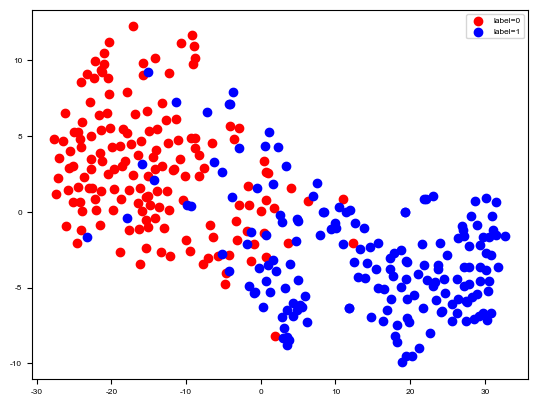

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

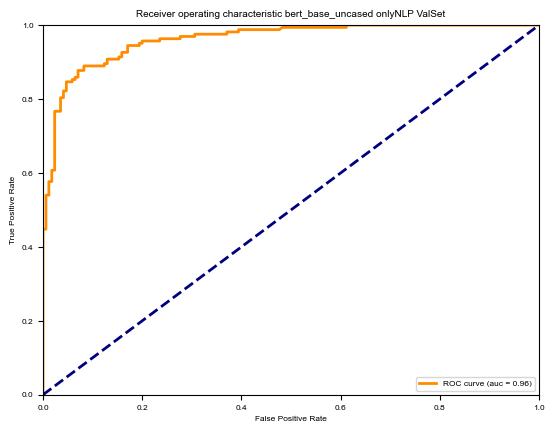

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

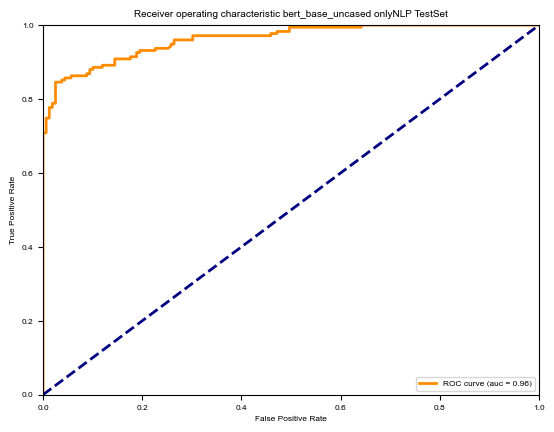

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Beginning AutoGluon training ...
AutoGluon will save models to "outputFigure/origin/bert_base_uncased/model/ml/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Mar 2 00:30:59 UTC 2022
Disk Space Avail:   283.54 GB / 1893.02 GB (15.0%)
Train Data Rows:    999
Train Data Columns: 768
Tuning Data Rows:    333
Tuning Data Columns: 768
Label Column: 768
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    224

               model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            XGBoost    0.904192   0.897898        0.020414       0.009486   2.969708                 0.020414                0.009486           2.969708            1       True         10
1         LightGBMXT    0.901198   0.900901        0.007541       0.003914   2.215614                 0.007541                0.003914           2.215614            1       True          3
2           LightGBM    0.898204   0.894895        0.008293       0.004209   5.770163                 0.008293                0.004209           5.770163            1       True          4
3   RandomForestEntr    0.898204   0.879880        0.112381       0.097657   0.811208                 0.112381                0.097657           0.811208            1       True          6
4   RandomForestGini    0.898204   0.885886        0.11

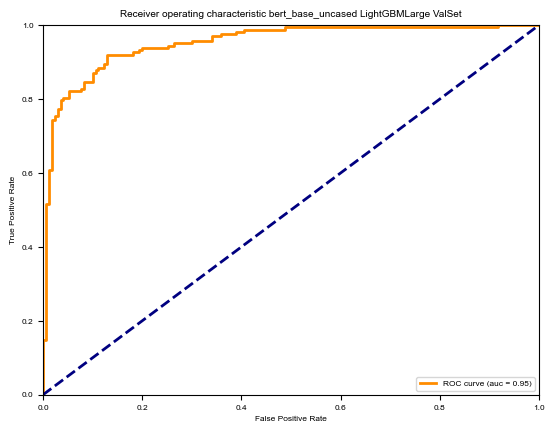

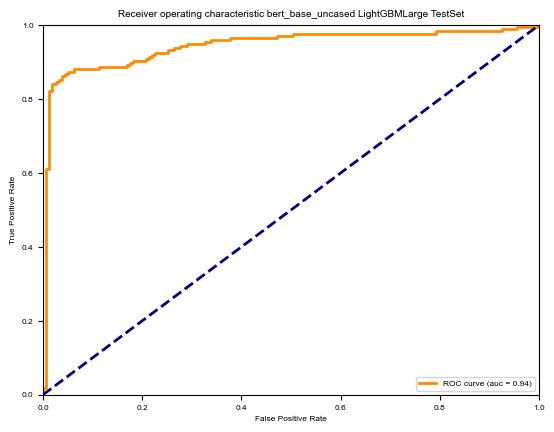

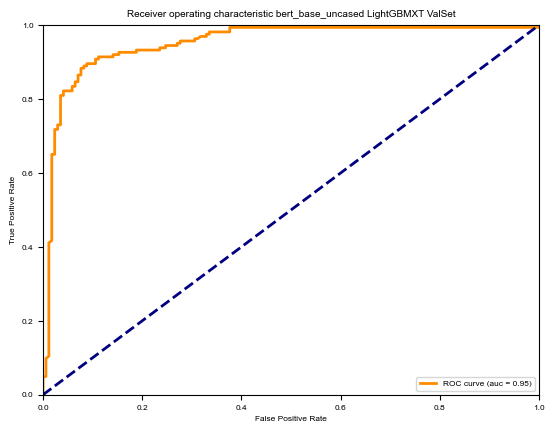

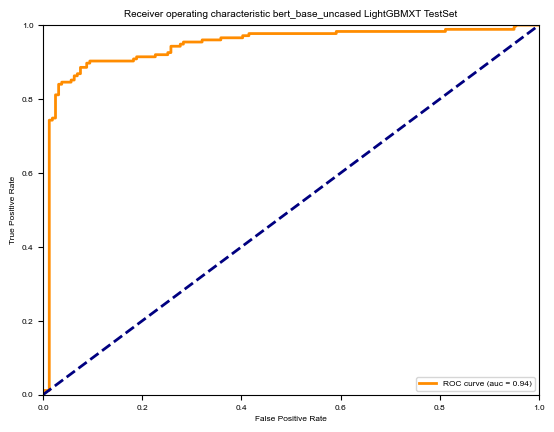

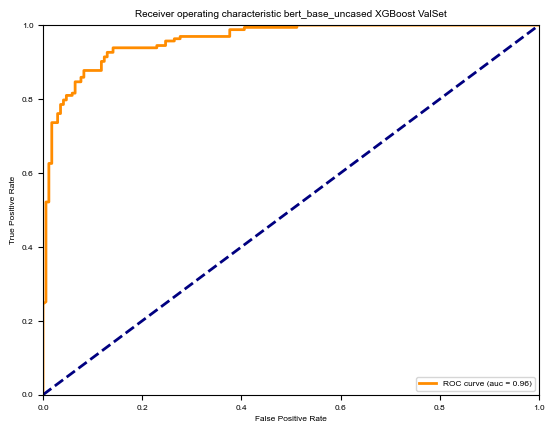

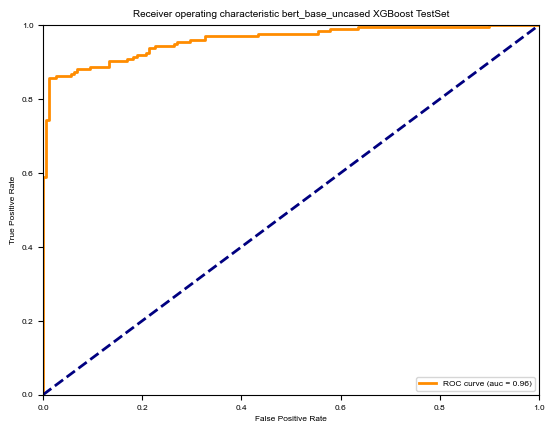

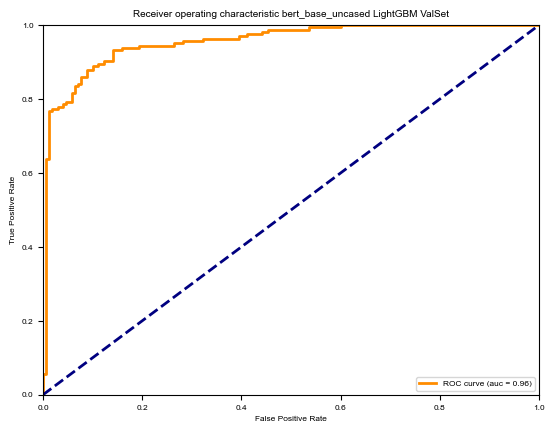

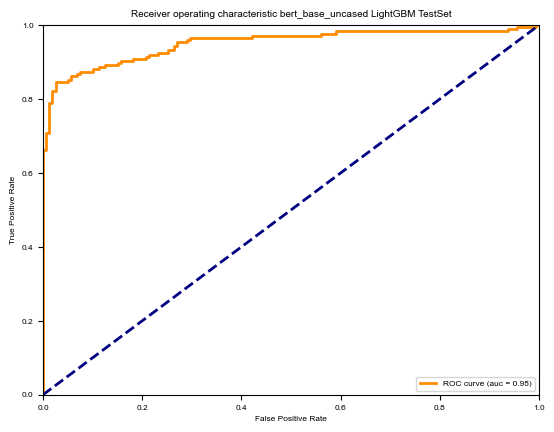

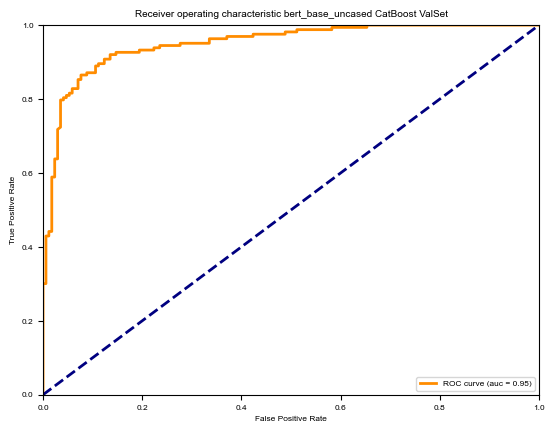

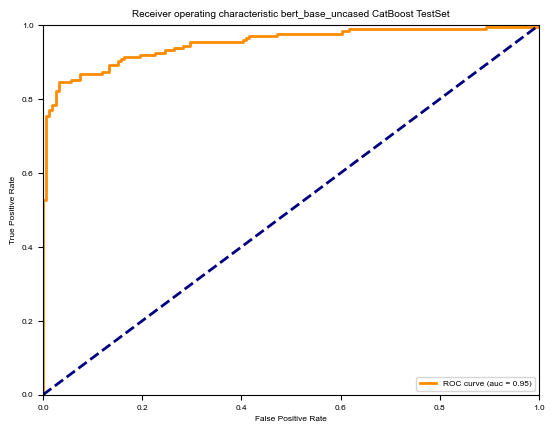

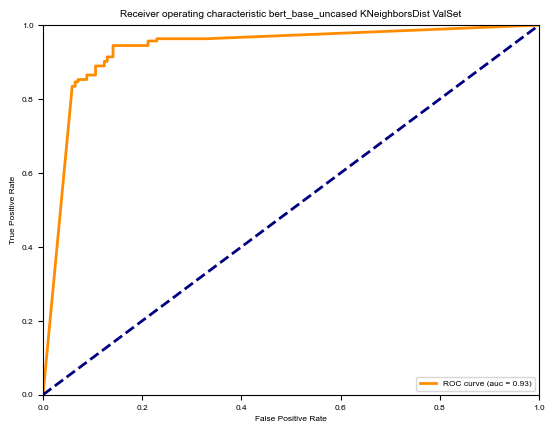

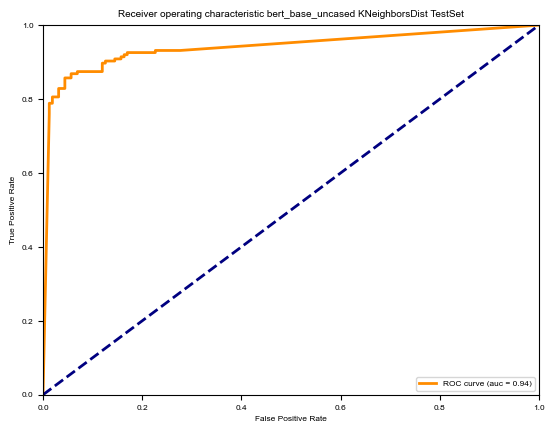

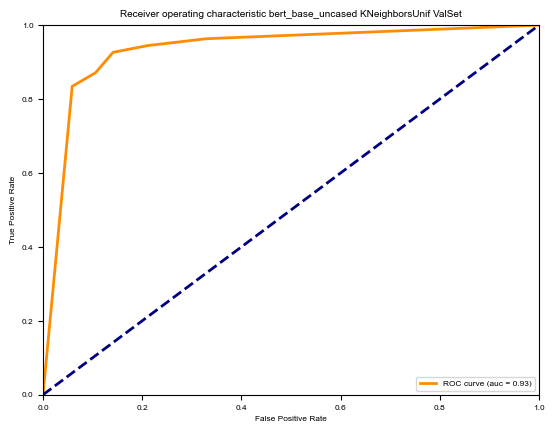

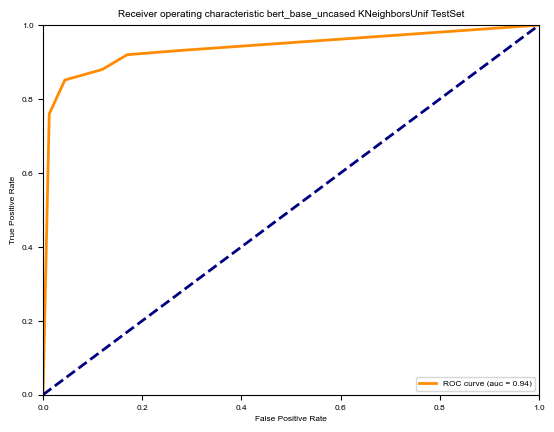

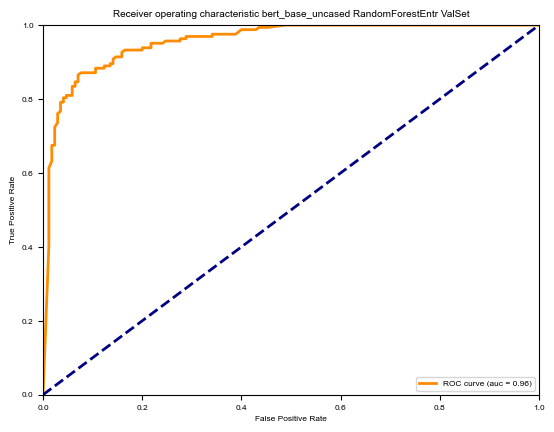

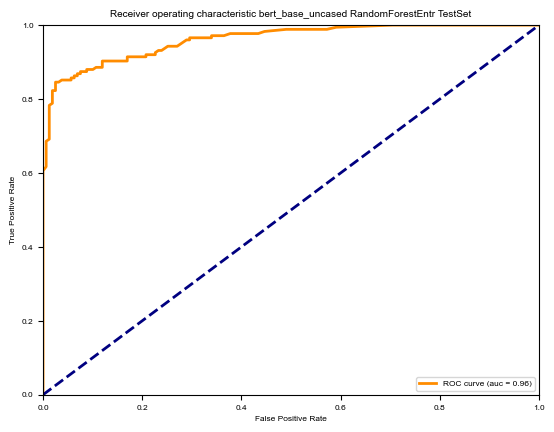

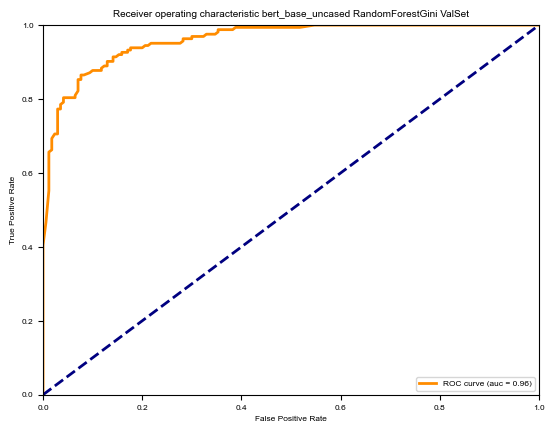

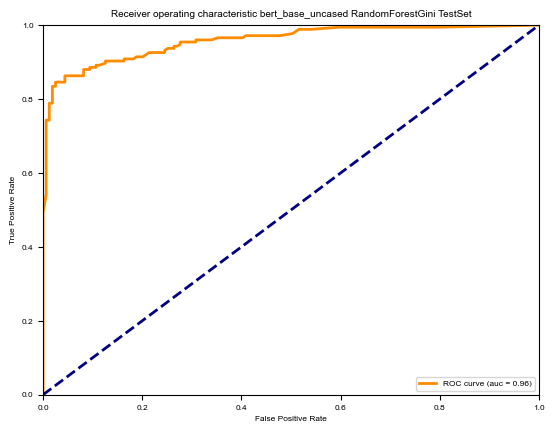

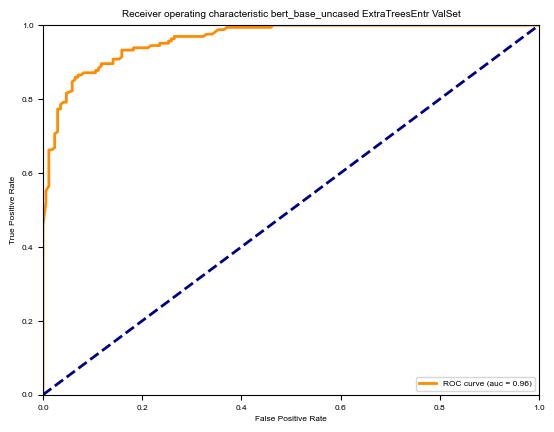

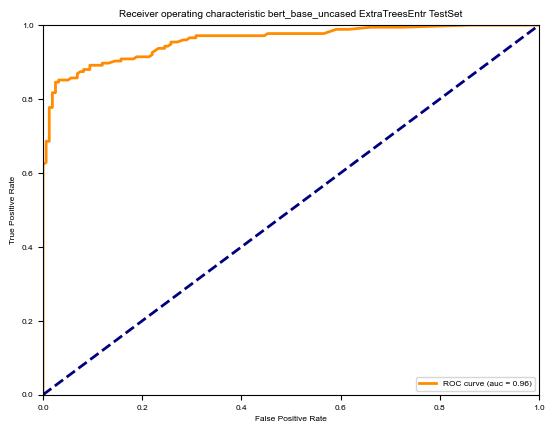

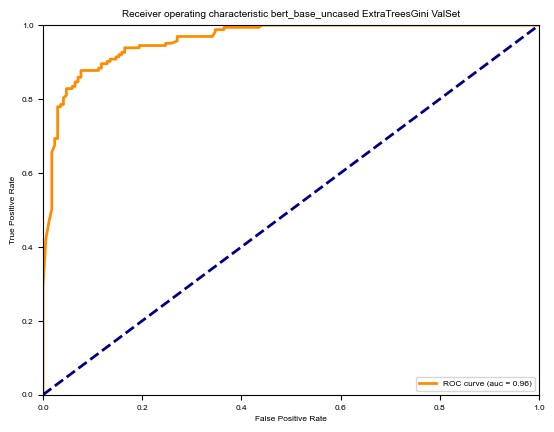

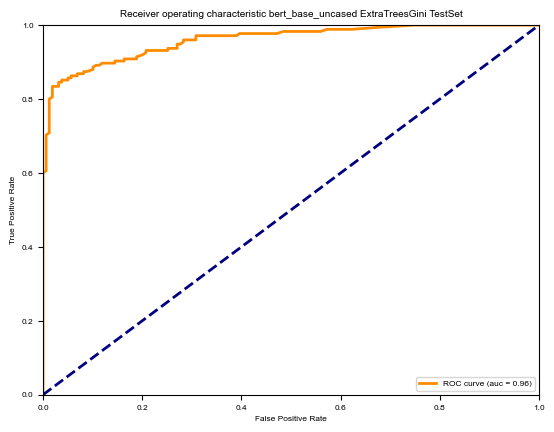

AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.2.

- Pytorch version is 1.13.1+cu117.

- Model will be saved to "/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp".

- Validation metric is "acc".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai



origin   m3e-base


1 GPUs are detected, and 1 GPUs will be used.
   - GPU 0 name: NVIDIA GeForce GTX 1070
   - GPU 0 memory: 7.40GB/8.59GB (Free/Total)
CUDA version is 11.7.

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 102 M 
1 | validation_metric | MulticlassAccuracy           | 0     
2 | loss_func         | CrossEntropyLoss             | 0     
-------------------------------------------------------------------
102 M     Trainable params
0         Non-trainable params
102 M     Total params
204.538   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3: 'val_acc' reached 0.56757 (best 0.56757), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=0-step=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 7: 'val_acc' reached 0.75676 (best 0.75676), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=0-step=7.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 11: 'val_acc' reached 0.75676 (best 0.75676), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=1-step=11.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 15: 'val_acc' reached 0.72973 (best 0.75676), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=1-step=15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 19: 'val_acc' reached 0.85285 (best 0.85285), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=2-step=19.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 23: 'val_acc' reached 0.84685 (best 0.85285), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=2-step=23.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 27: 'val_acc' reached 0.85886 (best 0.85886), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=3-step=27.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 31: 'val_acc' reached 0.87688 (best 0.87688), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=3-step=31.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 35: 'val_acc' reached 0.87688 (best 0.87688), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=4-step=35.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 39: 'val_acc' reached 0.88288 (best 0.88288), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=4-step=39.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 43: 'val_acc' reached 0.89489 (best 0.89489), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=5-step=43.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 47: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 51: 'val_acc' reached 0.88589 (best 0.89489), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=6-step=51.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 55: 'val_acc' reached 0.89189 (best 0.89489), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=6-step=55.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 59: 'val_acc' reached 0.89189 (best 0.89489), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=7-step=59.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 63: 'val_acc' reached 0.90390 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=7-step=63.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 67: 'val_acc' reached 0.90090 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp/epoch=8-step=67.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 71: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 75: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 79: 'val_acc' was not in top 3
`Trainer.fit` stopped: `max_epochs=10` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/origin/m3e-base/model/nlp
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

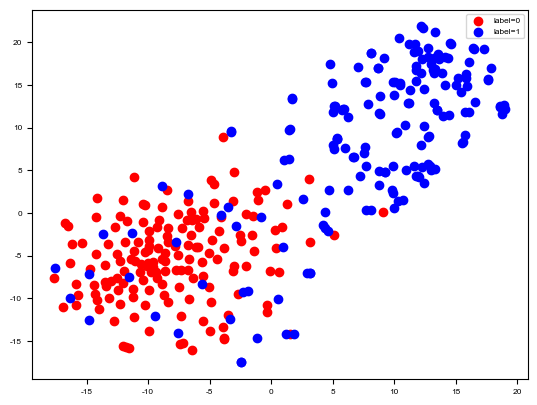

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

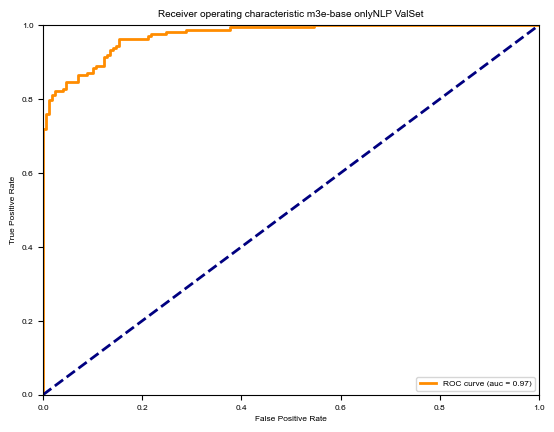

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

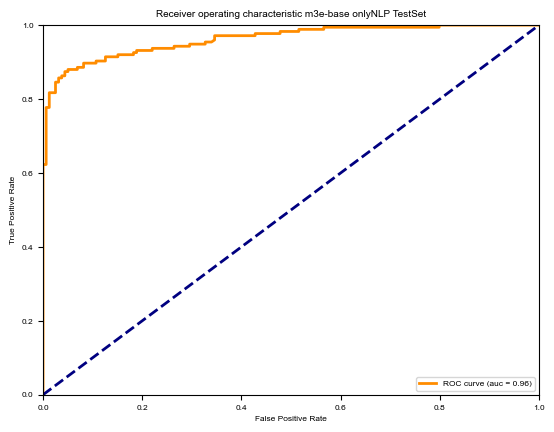

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Beginning AutoGluon training ...
AutoGluon will save models to "outputFigure/origin/m3e-base/model/ml/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Mar 2 00:30:59 UTC 2022
Disk Space Avail:   283.08 GB / 1893.02 GB (15.0%)
Train Data Rows:    999
Train Data Columns: 768
Tuning Data Rows:    333
Tuning Data Columns: 768
Label Column: 768
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    22158.32 MB


               model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     KNeighborsDist    0.922156   0.906907        0.027857       0.012219   0.062012                 0.027857                0.012219           0.062012            1       True          2
1     KNeighborsUnif    0.919162   0.903904        0.020450       0.082972   0.064654                 0.020450                0.082972           0.064654            1       True          1
2     ExtraTreesGini    0.910180   0.897898        0.125027       0.109646   0.774604                 0.125027                0.109646           0.774604            1       True          8
3     ExtraTreesEntr    0.904192   0.891892        0.118277       0.110984   0.779536                 0.118277                0.110984           0.779536            1       True          9
4   RandomForestGini    0.901198   0.888889        0.12

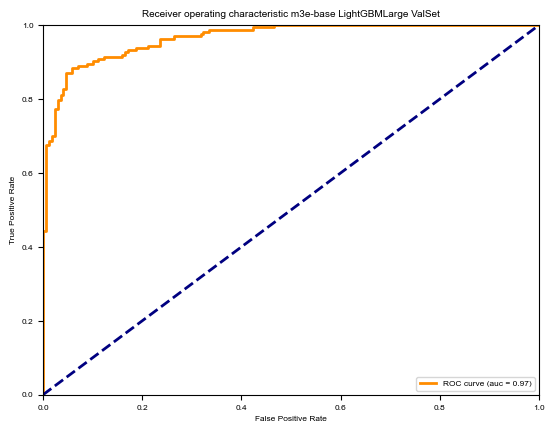

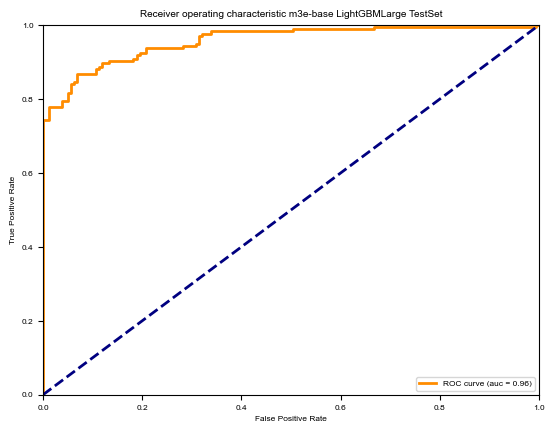

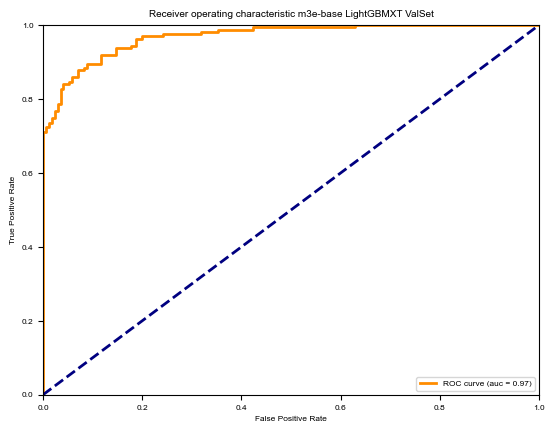

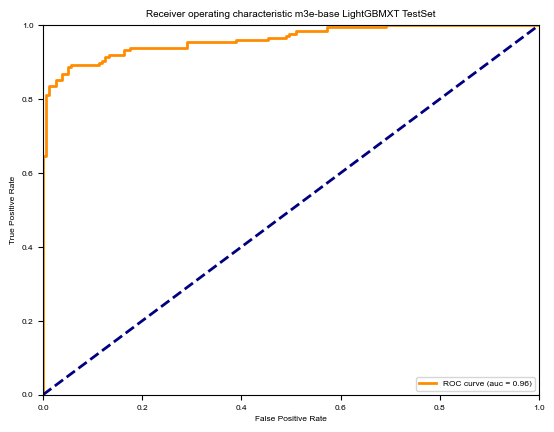

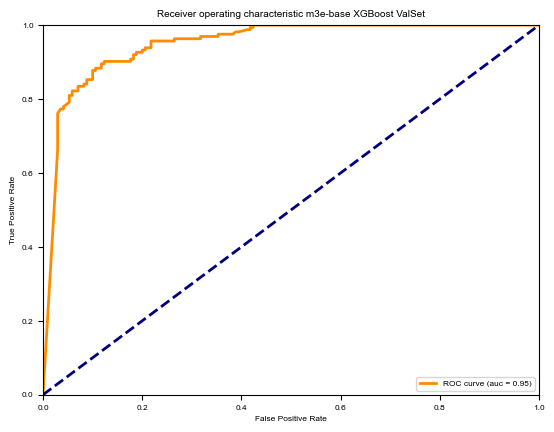

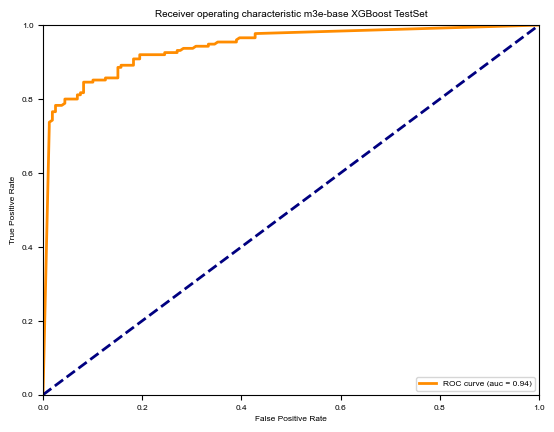

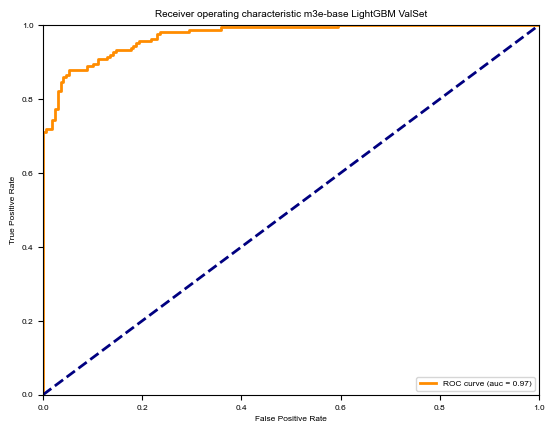

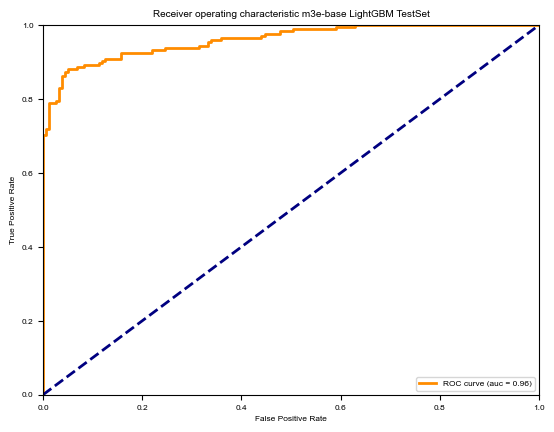

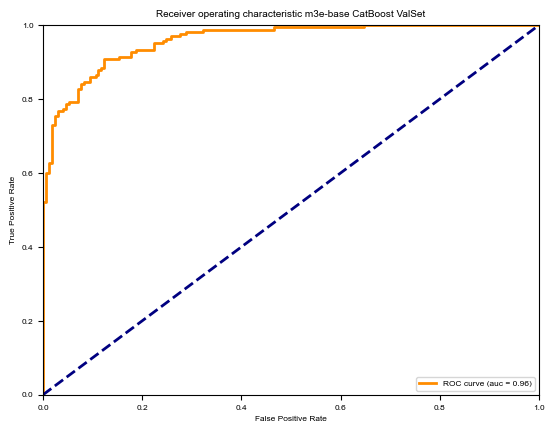

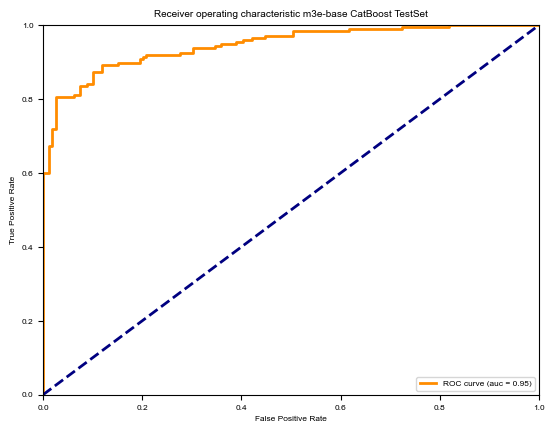

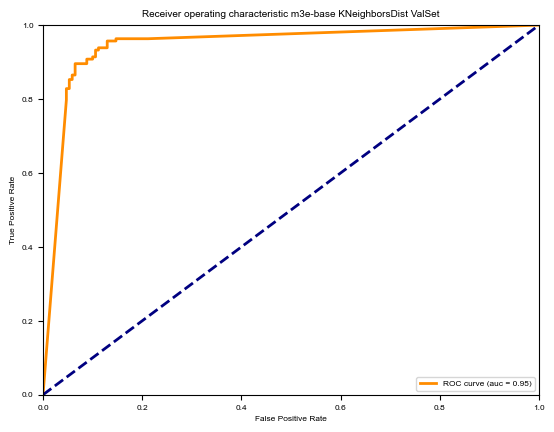

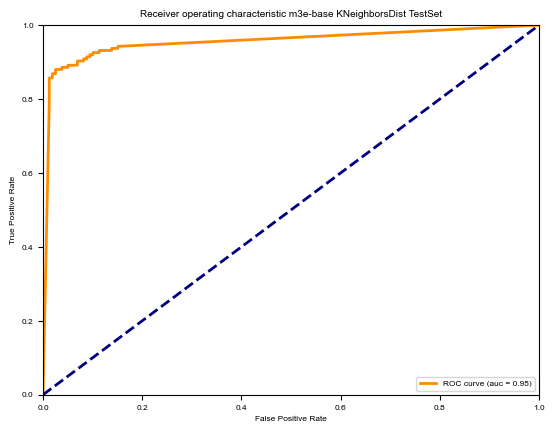

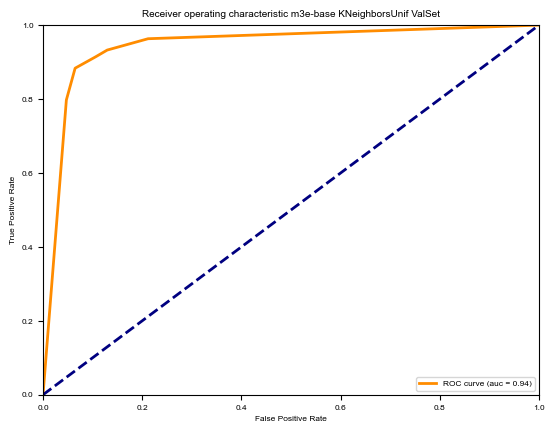

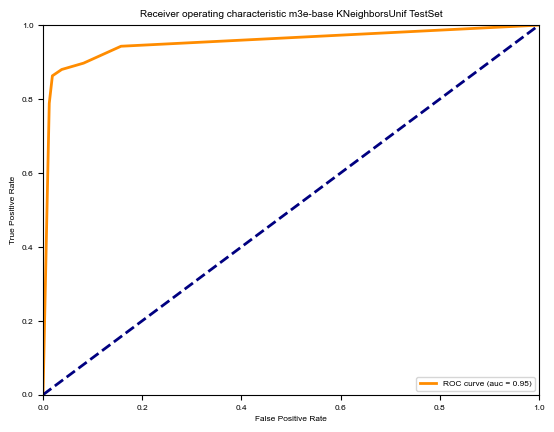

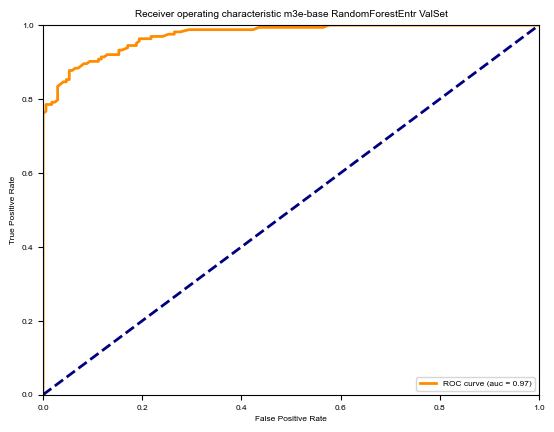

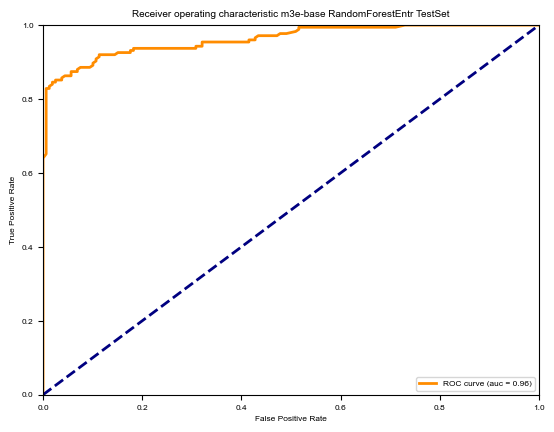

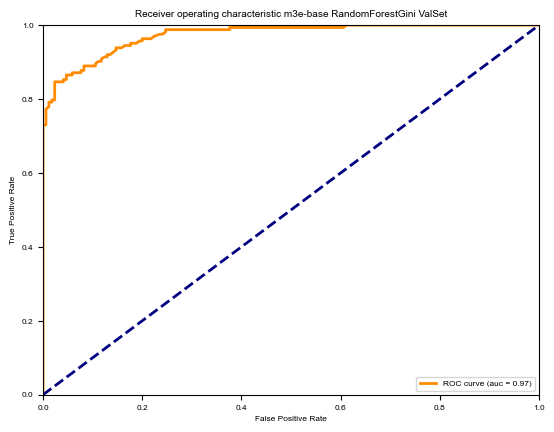

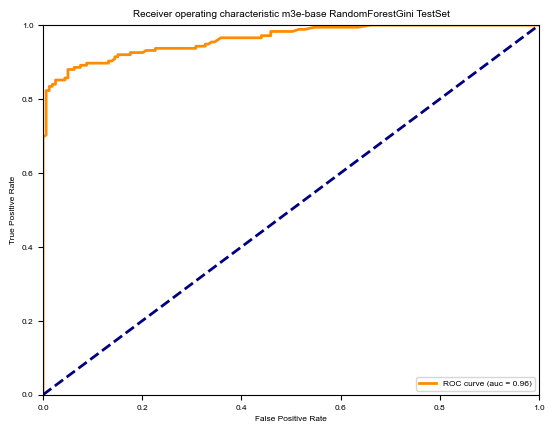

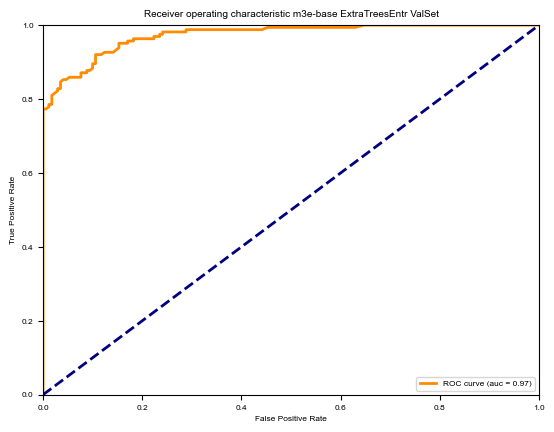

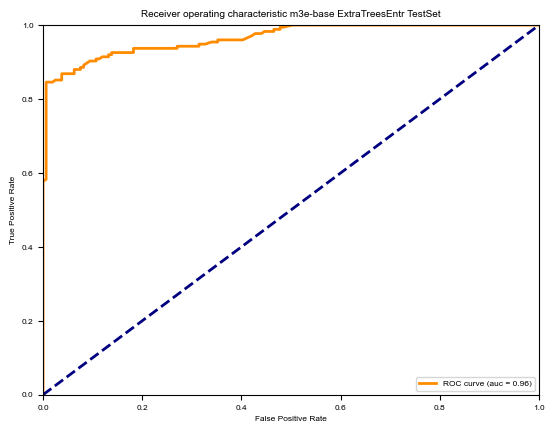

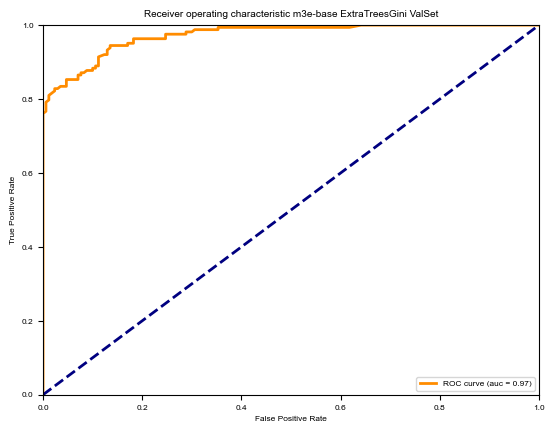

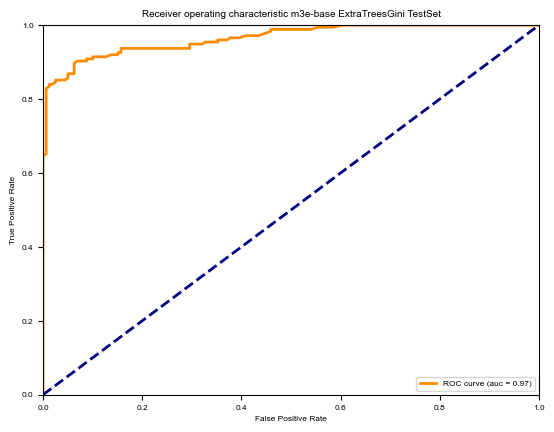

[0.9039039  0.90419162 0.9009009  0.9011976  0.9039039  0.88922156
 0.90690691 0.92215569 0.         0.        ]


In [19]:
result_origin = access_dataset(dataset_origin,'origin')
print(result_origin)

AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.2.

- Pytorch version is 1.13.1+cu117.

- Model will be saved to "/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp".

- Validation metric is "acc".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai



addSpace   bert-base-uncased


1 GPUs are detected, and 1 GPUs will be used.
   - GPU 0 name: NVIDIA GeForce GTX 1070
   - GPU 0 memory: 7.40GB/8.59GB (Free/Total)
CUDA version is 11.7.

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 109 M 
1 | validation_metric | MulticlassAccuracy           | 0     
2 | loss_func         | CrossEntropyLoss             | 0     
-------------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
218.968   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3: 'val_acc' reached 0.70871 (best 0.70871), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=0-step=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 7: 'val_acc' reached 0.84685 (best 0.84685), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=0-step=7.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 11: 'val_acc' reached 0.82883 (best 0.84685), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=1-step=11.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 15: 'val_acc' reached 0.79279 (best 0.84685), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=1-step=15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 19: 'val_acc' reached 0.87988 (best 0.87988), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=2-step=19.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 23: 'val_acc' reached 0.90090 (best 0.90090), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=2-step=23.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 27: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 31: 'val_acc' reached 0.89489 (best 0.90090), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=3-step=31.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 35: 'val_acc' reached 0.89790 (best 0.90090), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=4-step=35.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 39: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 43: 'val_acc' reached 0.90090 (best 0.90090), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=5-step=43.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 47: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 51: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 55: 'val_acc' reached 0.90390 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=6-step=55.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 59: 'val_acc' reached 0.90390 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=7-step=59.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 63: 'val_acc' reached 0.90991 (best 0.90991), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=7-step=63.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 67: 'val_acc' reached 0.90691 (best 0.90991), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=8-step=67.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 71: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 75: 'val_acc' reached 0.90691 (best 0.90991), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp/epoch=9-step=75.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 79: 'val_acc' was not in top 3
`Trainer.fit` stopped: `max_epochs=10` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/addSpace/bert_base_uncased/model/nlp
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

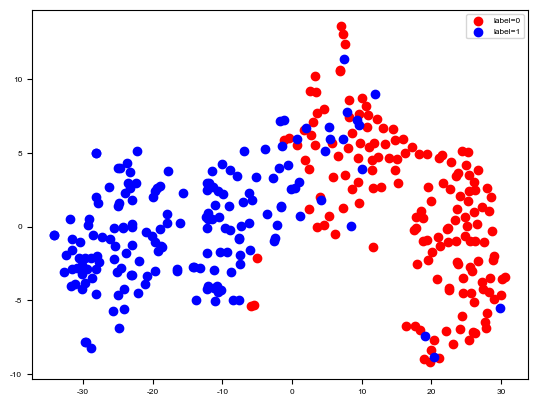

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

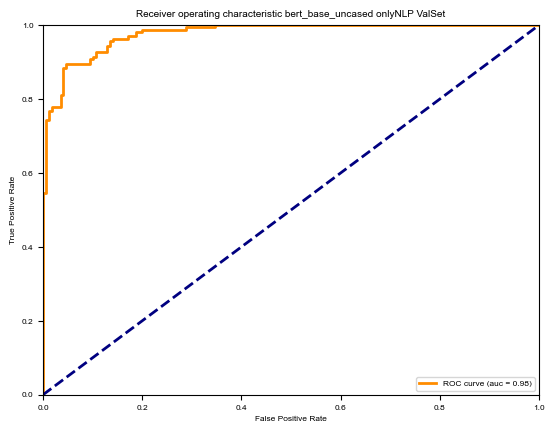

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

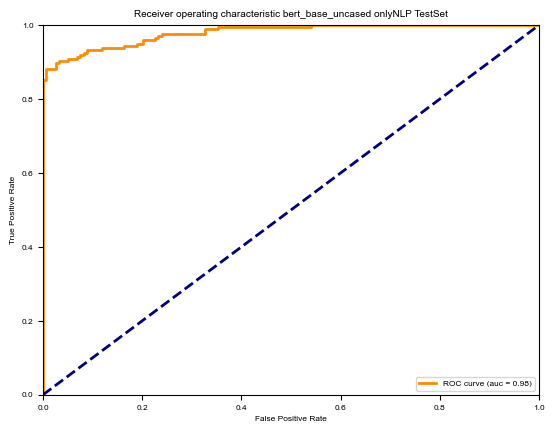

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Beginning AutoGluon training ...
AutoGluon will save models to "outputFigure/addSpace/bert_base_uncased/model/ml/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Mar 2 00:30:59 UTC 2022
Disk Space Avail:   282.59 GB / 1893.02 GB (14.9%)
Train Data Rows:    999
Train Data Columns: 768
Tuning Data Rows:    333
Tuning Data Columns: 768
Label Column: 768
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2

               model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMXT    0.931138   0.912913        0.010087       0.005467   2.454331                 0.010087                0.005467           2.454331            1       True          3
1   RandomForestEntr    0.931138   0.903904        0.111229       0.150630   1.229423                 0.111229                0.150630           1.229423            1       True          6
2     ExtraTreesGini    0.931138   0.906907        0.117487       0.121497   0.837153                 0.117487                0.121497           0.837153            1       True          8
3           LightGBM    0.928144   0.909910        0.012303       0.004617   6.313818                 0.012303                0.004617           6.313818            1       True          4
4           CatBoost    0.928144   0.912913        0.03

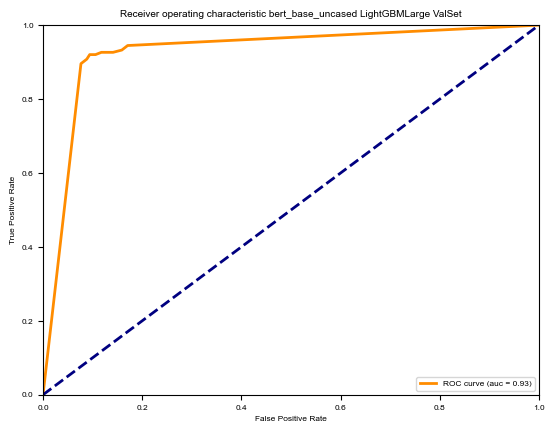

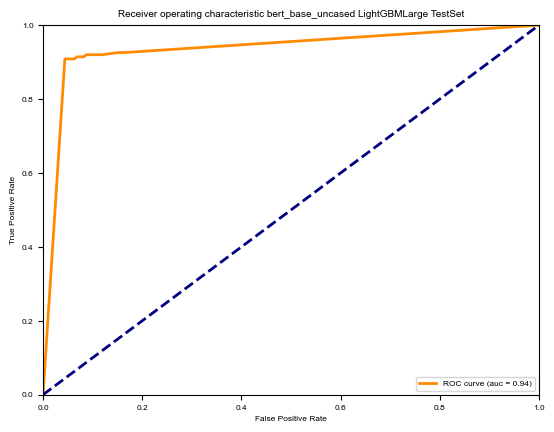

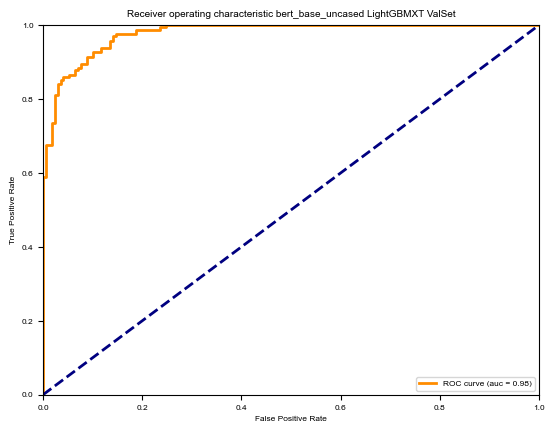

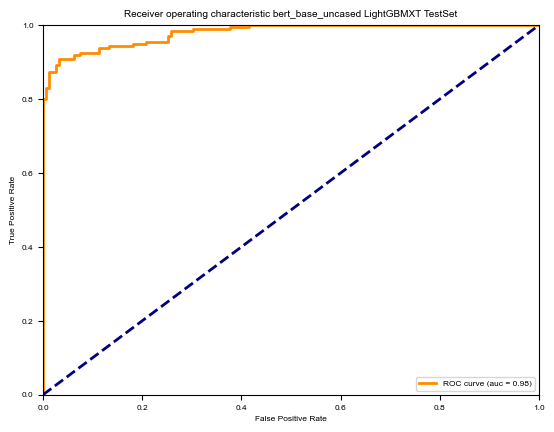

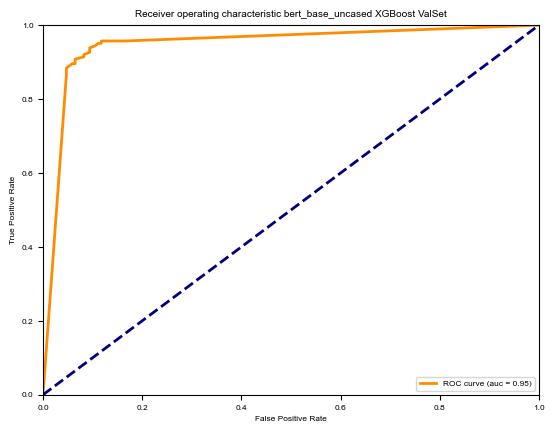

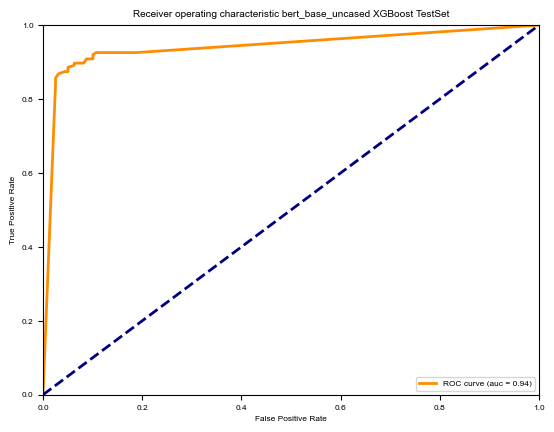

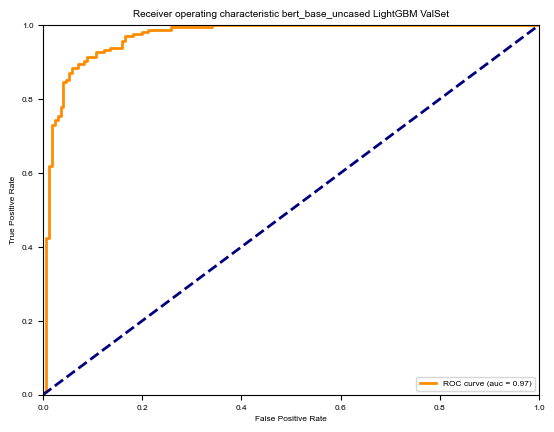

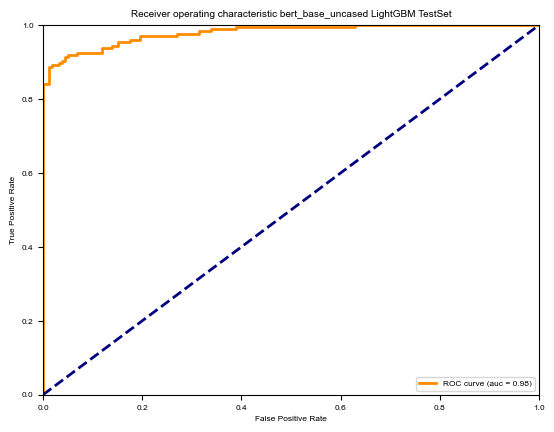

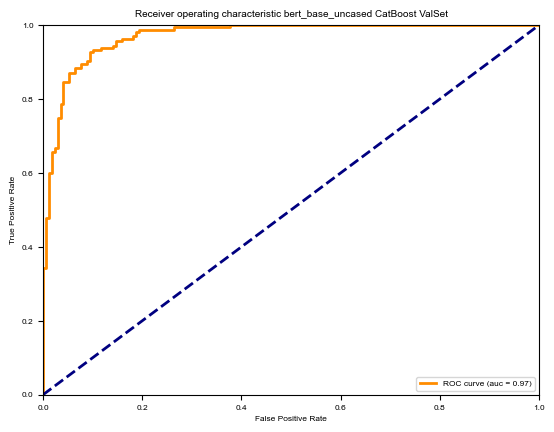

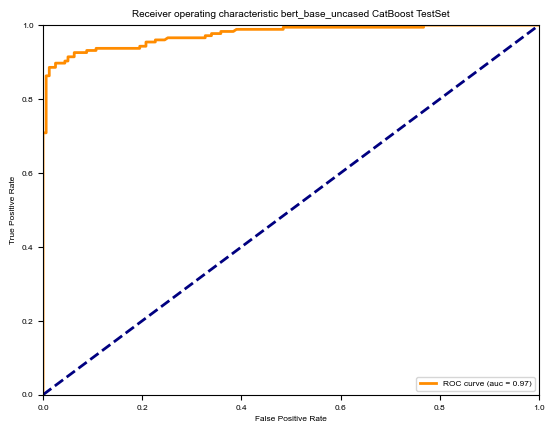

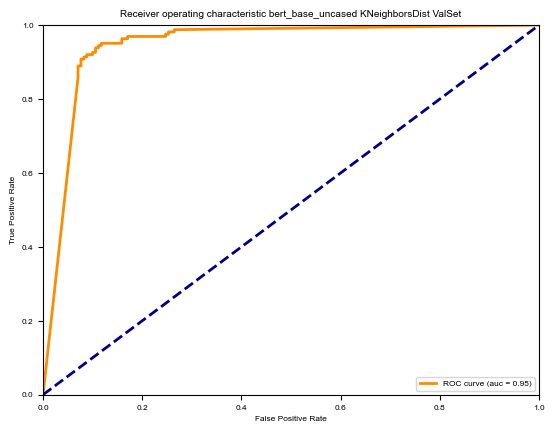

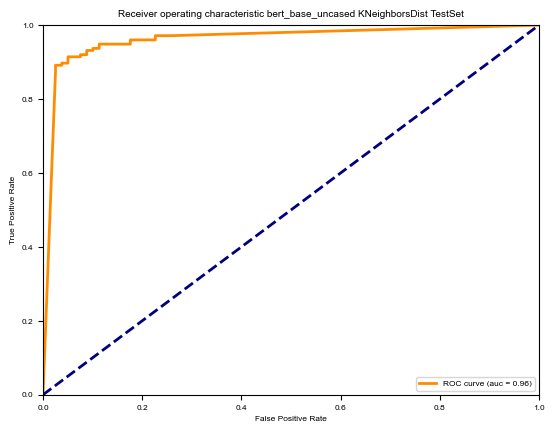

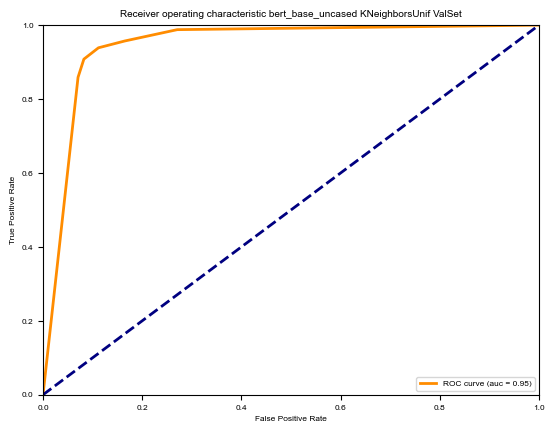

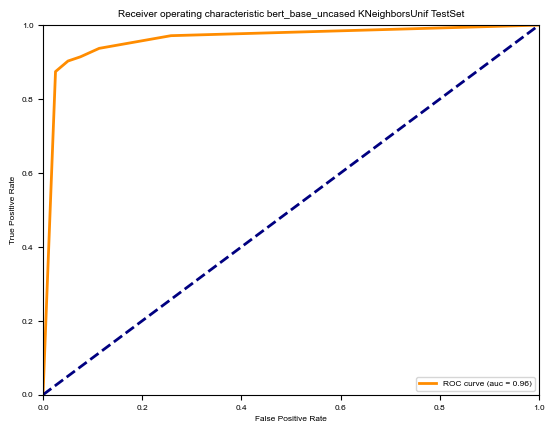

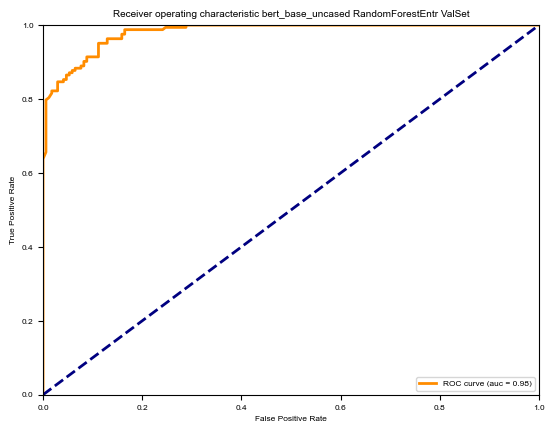

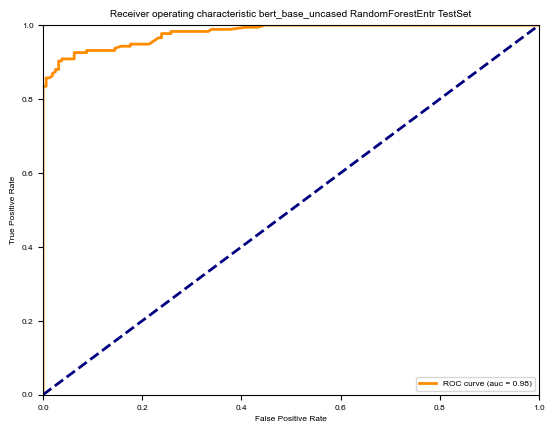

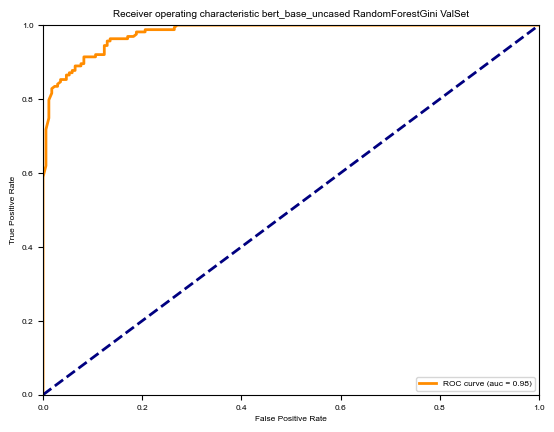

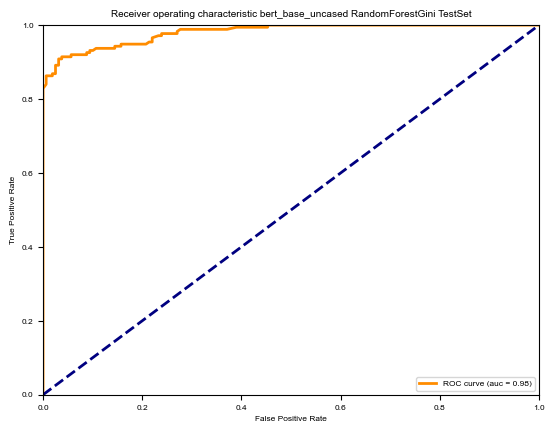

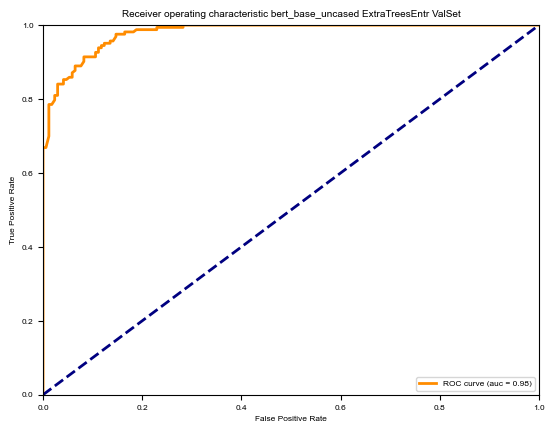

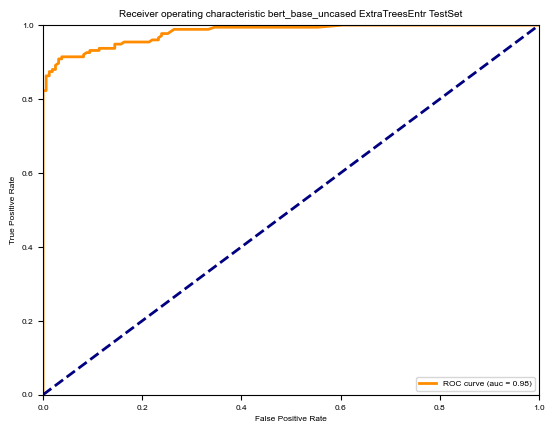

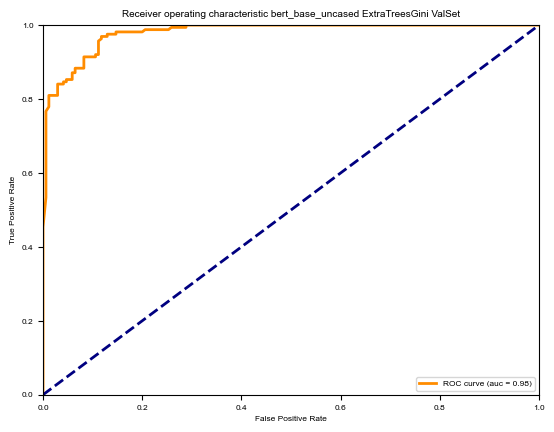

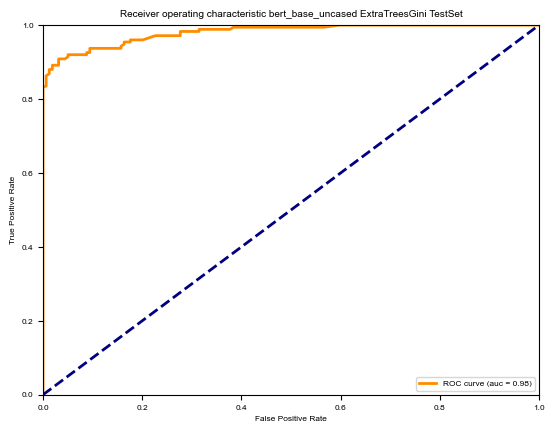

AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.2.

- Pytorch version is 1.13.1+cu117.

- Model will be saved to "/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp".

- Validation metric is "acc".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai



addSpace   m3e-base


1 GPUs are detected, and 1 GPUs will be used.
   - GPU 0 name: NVIDIA GeForce GTX 1070
   - GPU 0 memory: 7.40GB/8.59GB (Free/Total)
CUDA version is 11.7.

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 102 M 
1 | validation_metric | MulticlassAccuracy           | 0     
2 | loss_func         | CrossEntropyLoss             | 0     
-------------------------------------------------------------------
102 M     Trainable params
0         Non-trainable params
102 M     Total params
204.538   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3: 'val_acc' reached 0.50751 (best 0.50751), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=0-step=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 7: 'val_acc' reached 0.50150 (best 0.50751), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=0-step=7.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 11: 'val_acc' reached 0.85285 (best 0.85285), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=1-step=11.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 15: 'val_acc' reached 0.78378 (best 0.85285), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=1-step=15.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 19: 'val_acc' reached 0.87387 (best 0.87387), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=2-step=19.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 23: 'val_acc' reached 0.87087 (best 0.87387), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=2-step=23.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 27: 'val_acc' reached 0.87387 (best 0.87387), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=3-step=27.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 31: 'val_acc' reached 0.87387 (best 0.87387), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=3-step=31.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 35: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 39: 'val_acc' reached 0.88889 (best 0.88889), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=4-step=39.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 43: 'val_acc' reached 0.89489 (best 0.89489), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=5-step=43.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 47: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 51: 'val_acc' reached 0.89189 (best 0.89489), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=6-step=51.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 55: 'val_acc' reached 0.89189 (best 0.89489), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=6-step=55.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 59: 'val_acc' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 63: 'val_acc' reached 0.90390 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=7-step=63.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 67: 'val_acc' reached 0.90090 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=8-step=67.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 71: 'val_acc' reached 0.90390 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=8-step=71.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 75: 'val_acc' reached 0.90390 (best 0.90390), saving model to '/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/epoch=9-step=75.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 79: 'val_acc' was not in top 3
`Trainer.fit` stopped: `max_epochs=10` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

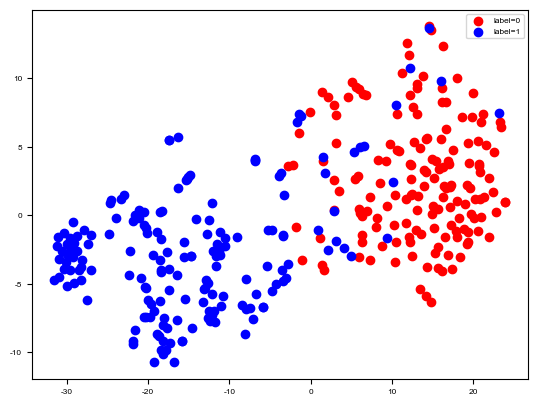

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

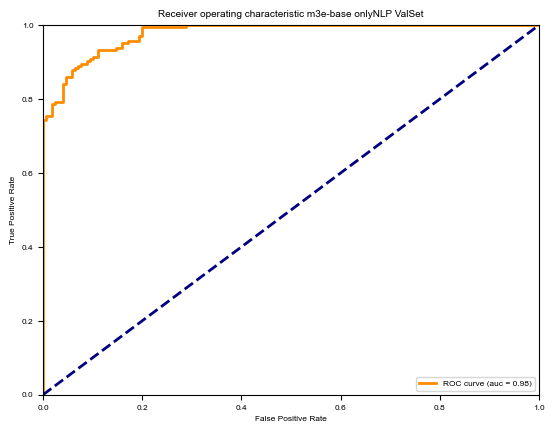

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

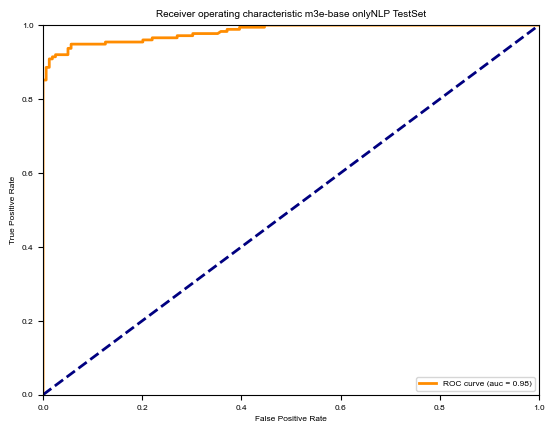

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Beginning AutoGluon training ...
AutoGluon will save models to "outputFigure/addSpace/m3e-base/model/ml/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Mar 2 00:30:59 UTC 2022
Disk Space Avail:   282.12 GB / 1893.02 GB (14.9%)
Train Data Rows:    999
Train Data Columns: 768
Tuning Data Rows:    333
Tuning Data Columns: 768
Label Column: 768
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    21599.94 M

               model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     KNeighborsDist    0.958084   0.918919        0.025513       0.032125   0.064798                 0.025513                0.032125           0.064798            1       True          2
1     KNeighborsUnif    0.955090   0.915916        0.039236       0.080370   0.067647                 0.039236                0.080370           0.067647            1       True          1
2           CatBoost    0.949102   0.921922        0.031594       0.009784  13.549247                 0.031594                0.009784          13.549247            1       True          7
3   RandomForestGini    0.949102   0.903904        0.113467       0.097776   0.910937                 0.113467                0.097776           0.910937            1       True          5
4     ExtraTreesEntr    0.949102   0.909910        0.11

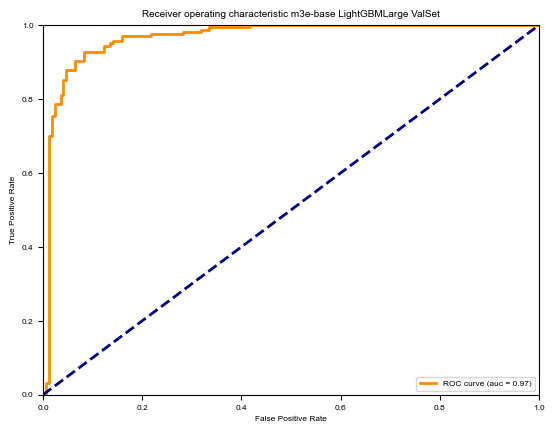

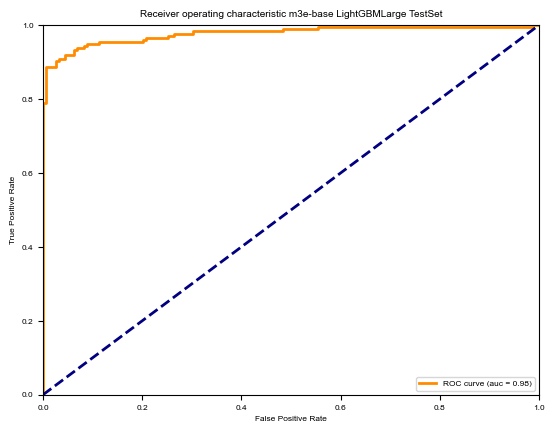

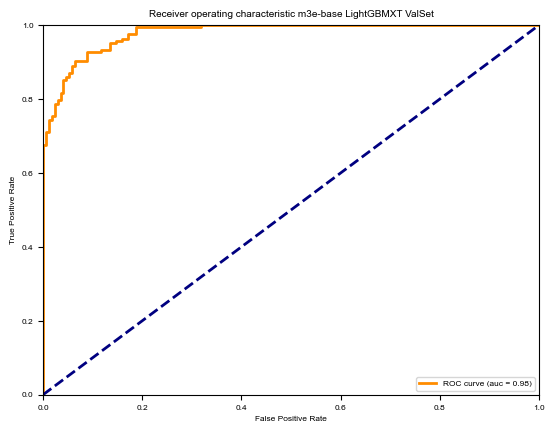

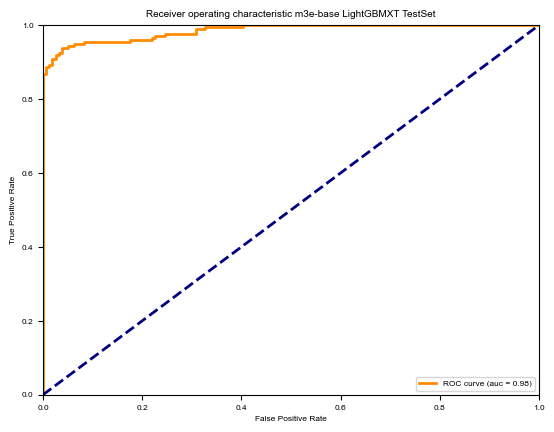

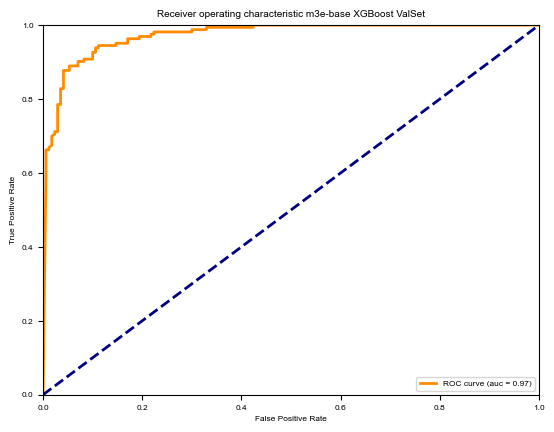

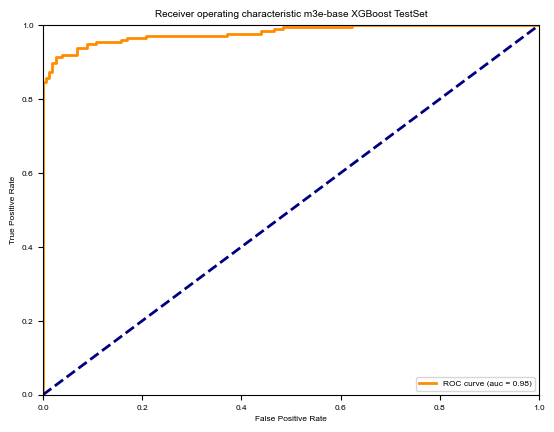

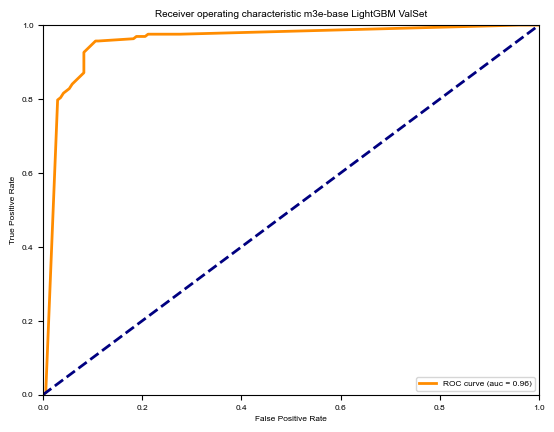

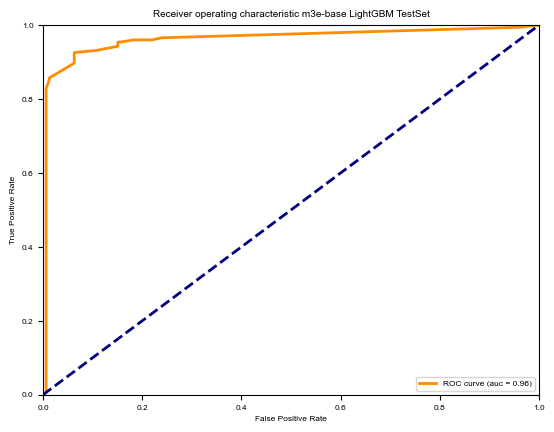

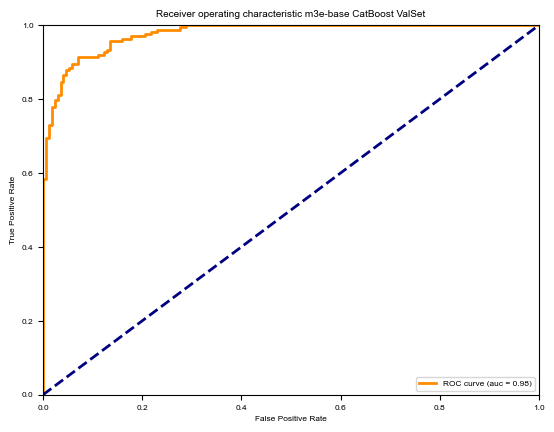

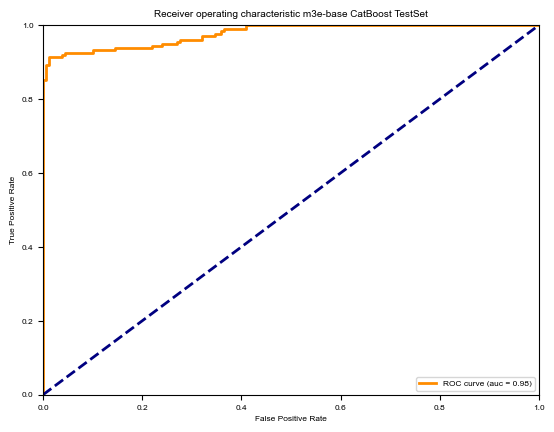

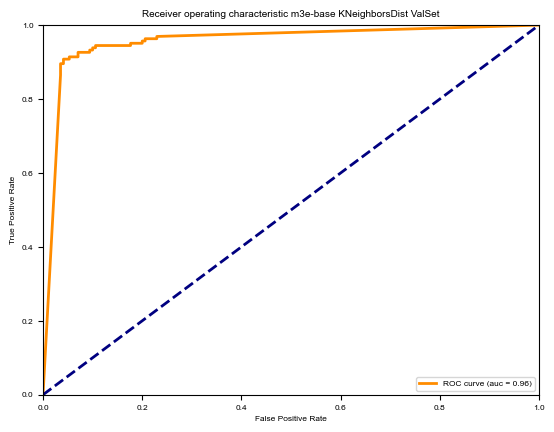

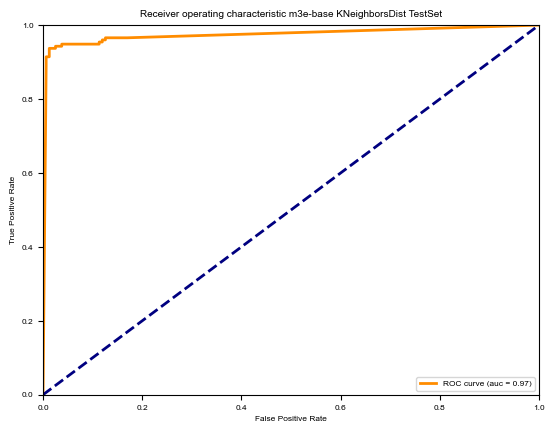

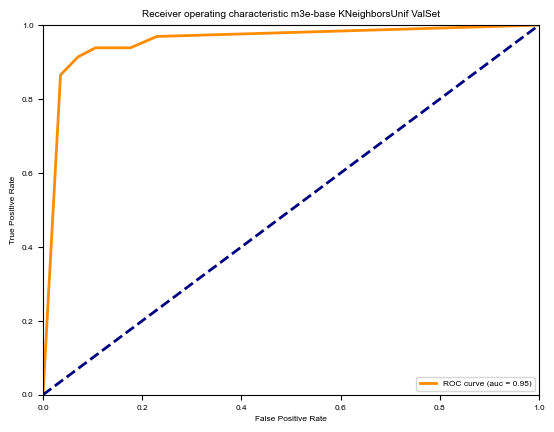

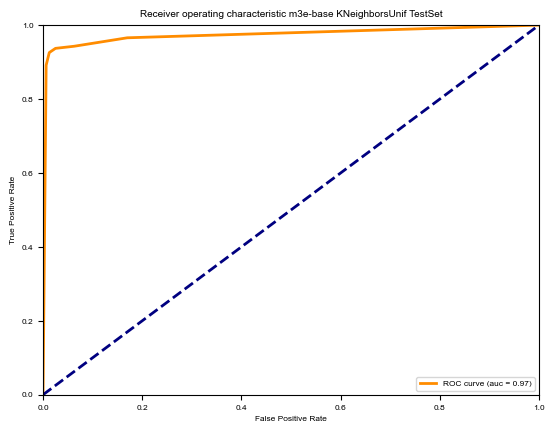

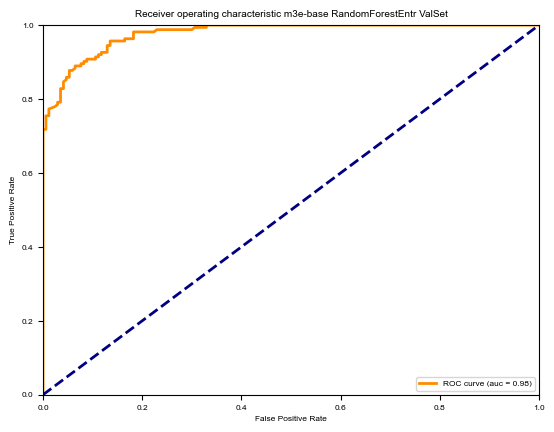

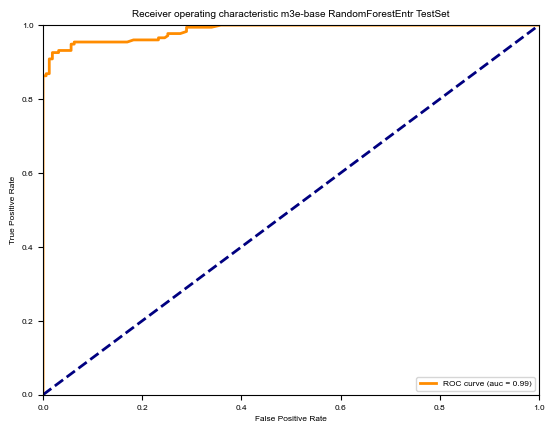

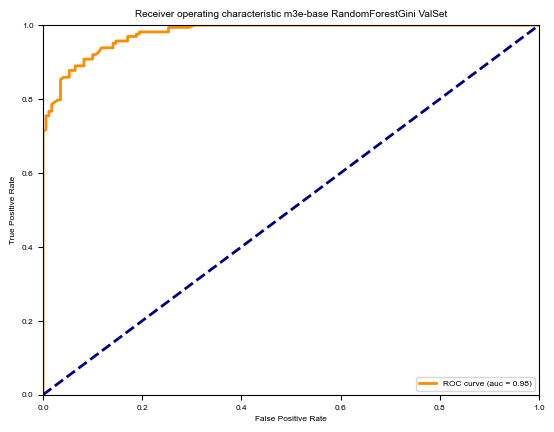

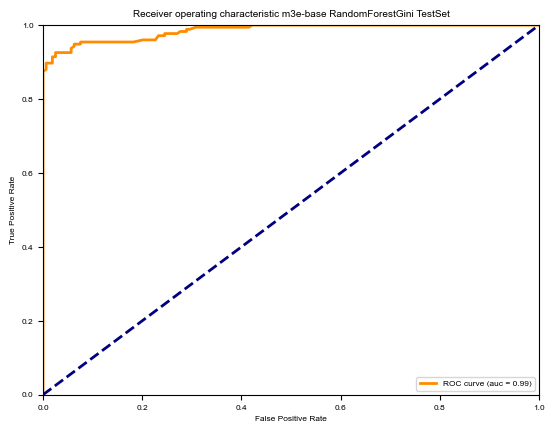

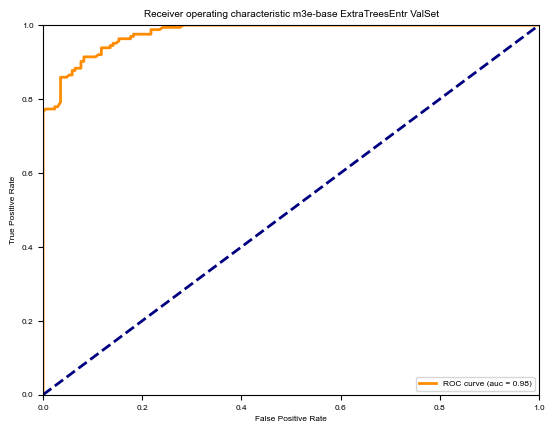

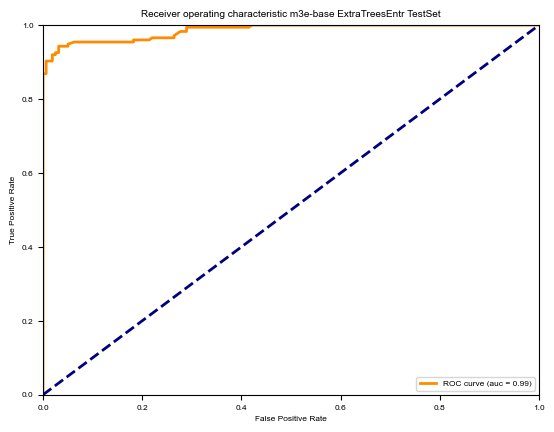

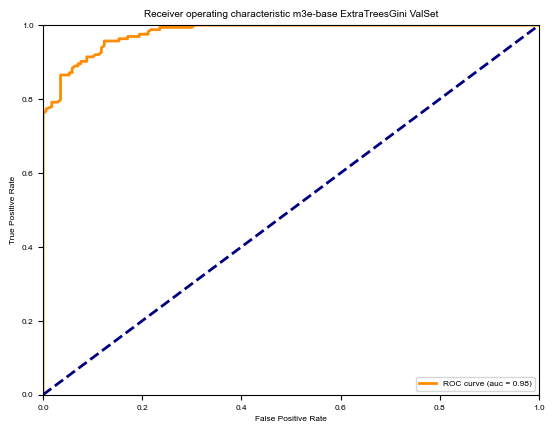

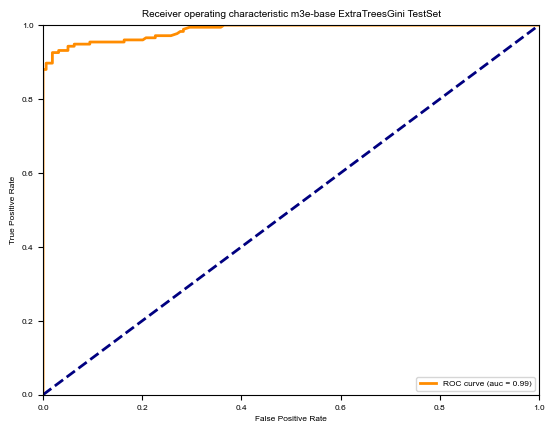

[0.90990991 0.91916168 0.91891892 0.90718563 0.9039039  0.94011976
 0.92492492 0.91317365 0.         0.        ]


In [20]:
# 添加空格
dataset_origin_add_space = dataset_origin.copy()
dataset_origin_add_space['Value'] = dataset_origin_add_space.apply(lambda x: ' '.join(list(x['Value'])), axis=1)
result_add_space = access_dataset(dataset_origin_add_space,'addSpace')
print(result_add_space)

Beginning AutoGluon training ...
AutoGluon will save models to "outputFigure/intEncode/model/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Mar 2 00:30:59 UTC 2022
Disk Space Avail:   285.70 GB / 1893.02 GB (15.1%)
Train Data Rows:    999
Train Data Columns: 111
Tuning Data Rows:    333
Tuning Data Columns: 111
Label Column: 111
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    25425.5 MB
	Train Dat

               model  score_test  score_val  pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            XGBoost    0.877246   0.867868        0.018702       0.003424  0.335731                 0.018702                0.003424           0.335731            1       True         11
1      LightGBMLarge    0.868263   0.870871        0.041745       0.008440  1.109826                 0.041745                0.008440           1.109826            1       True         13
2           LightGBM    0.853293   0.882883        0.014086       0.003932  0.492117                 0.014086                0.003932           0.492117            1       True          4
3         LightGBMXT    0.841317   0.855856        0.062265       0.013741  2.189595                 0.062265                0.013741           2.189595            1       True          3
4           CatBoost    0.835329   0.867868        0.009499 

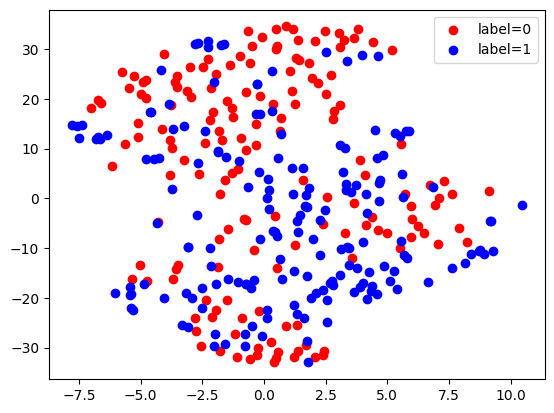

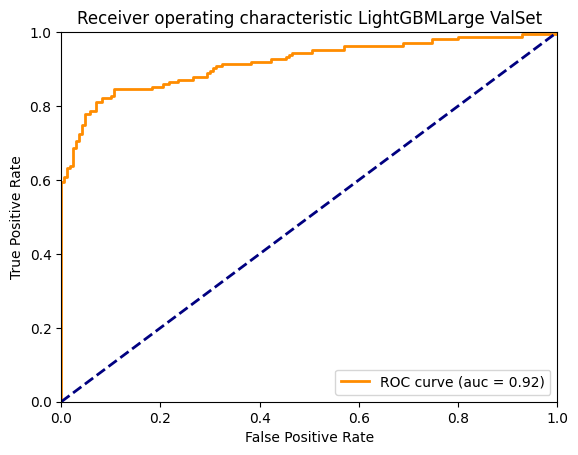

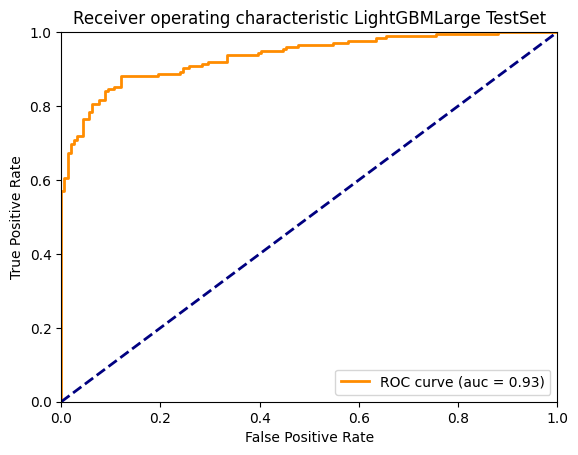

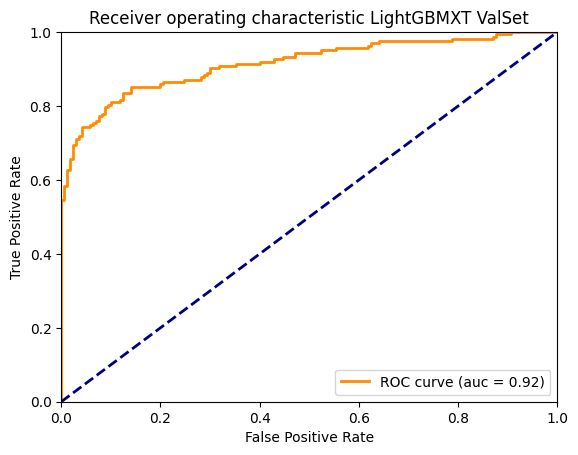

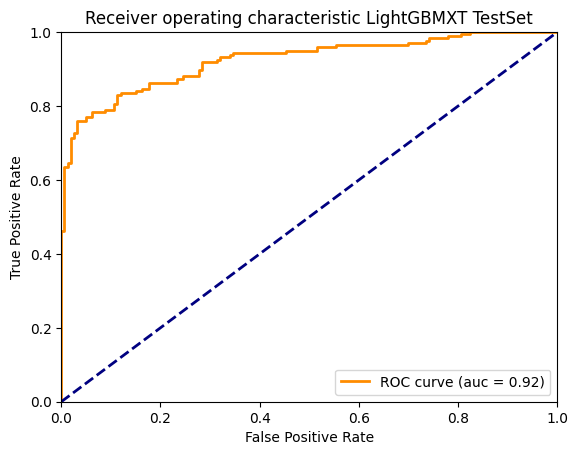

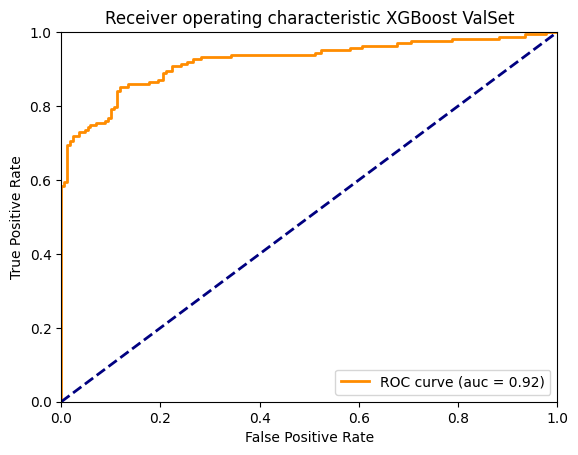

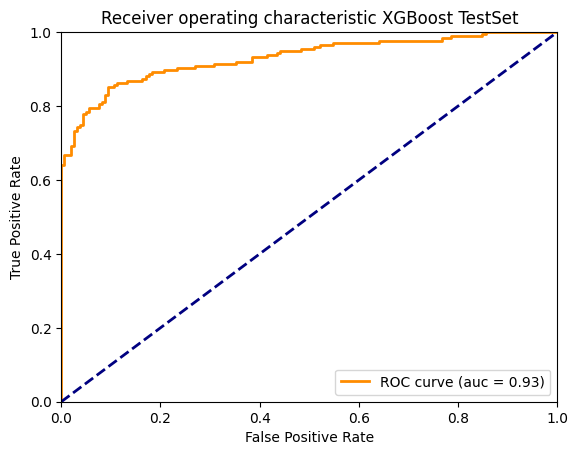

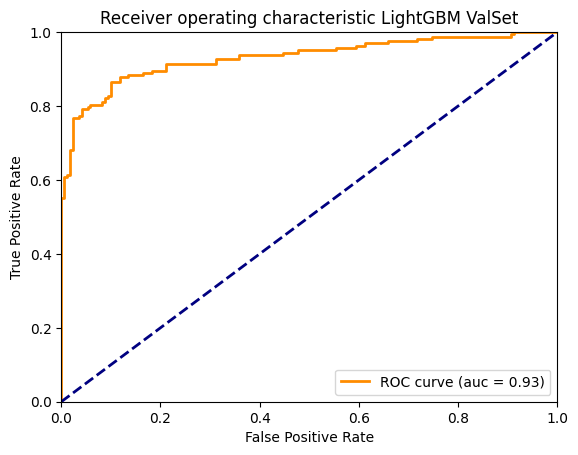

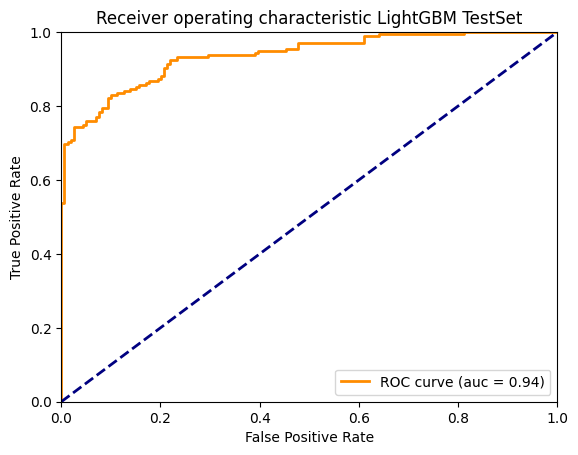

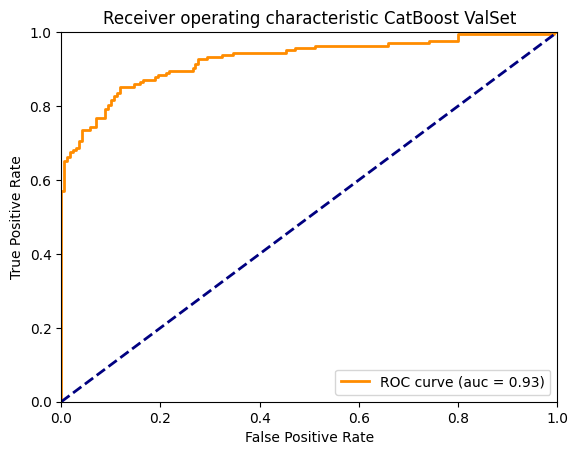

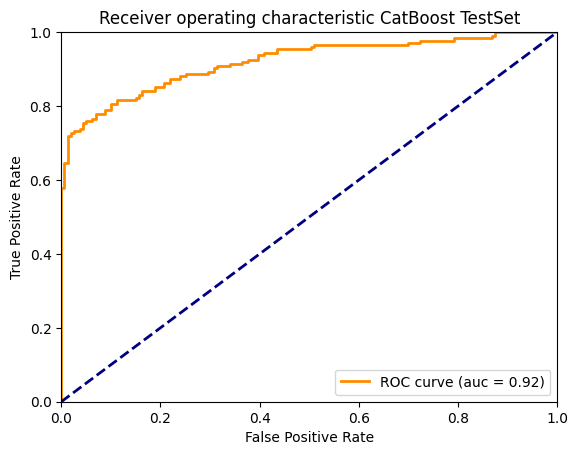

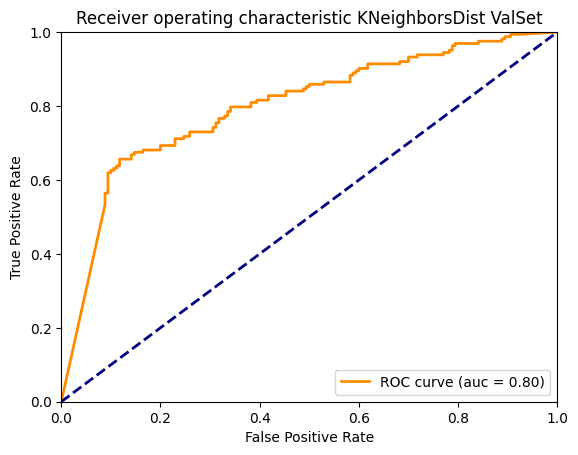

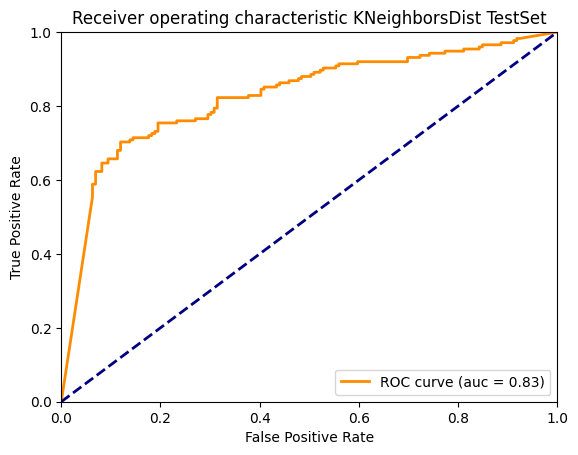

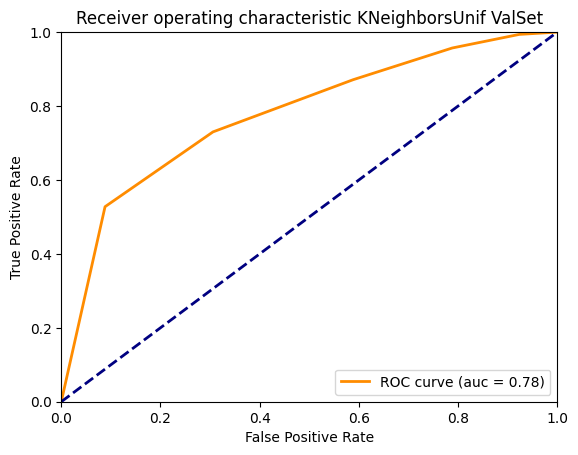

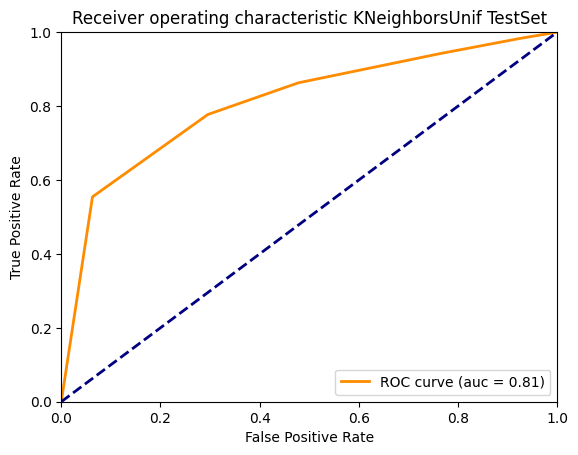

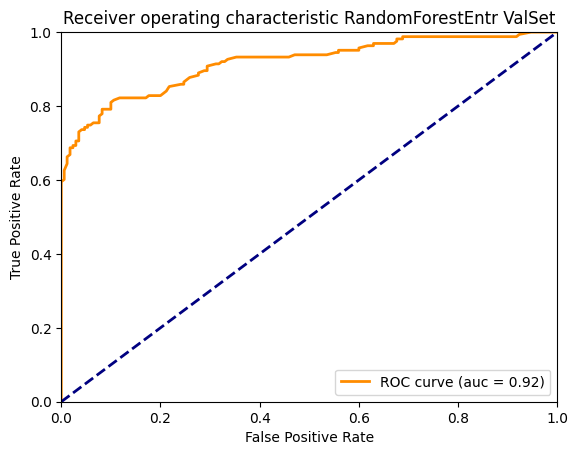

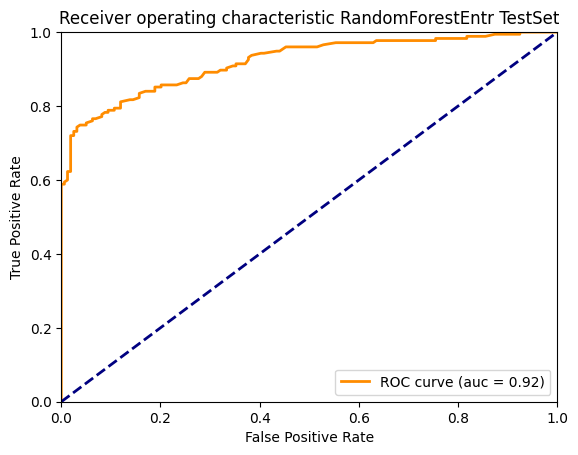

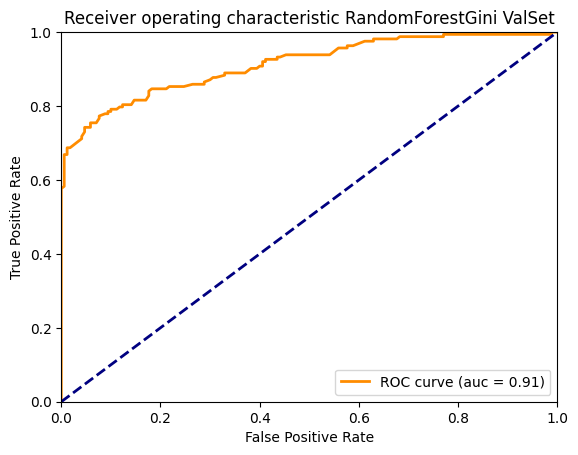

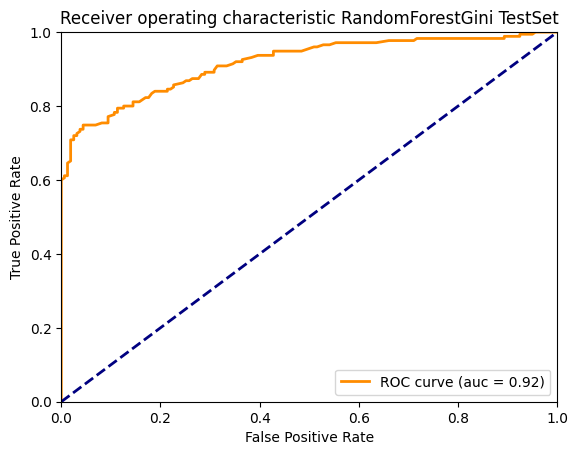

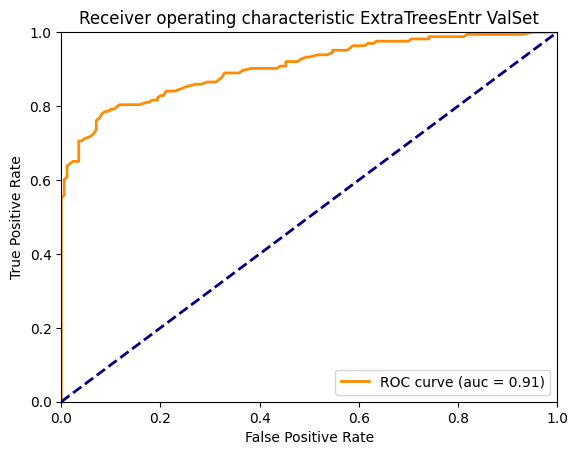

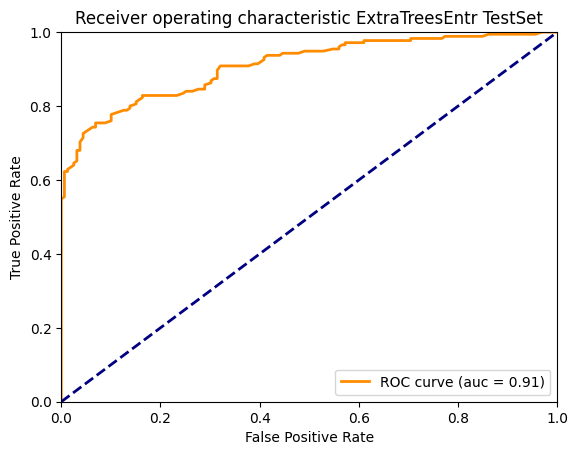

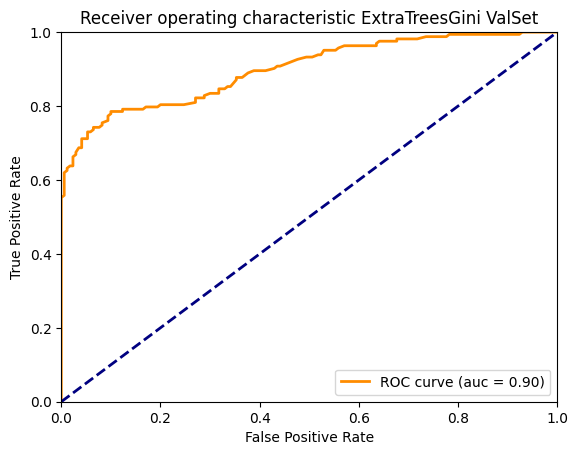

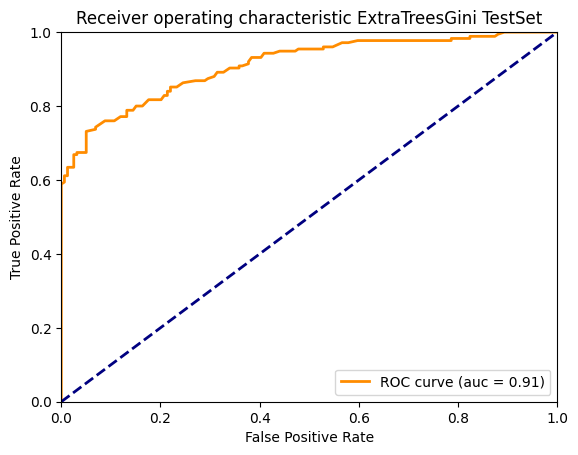

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   X[i,0:finallist[i].__len__()] = finallist[i]                                            │
│   14 y = np.array(dataset_origin['Label'])                                                       │
│   15 dataset_origin_int_encode = pd.DataFrame(np.hstack([X, np.expand_dims(y, -1)]))             │
│ ❱ 16 result_int_encode = access_dataset(dataset_origin_int_encode,'intEncode',use_nlp=False)     │
│   17 print(result_int_encode)                                                                    │
│   18                                                                                             │
│                                                                                                  │
│ in access_dataset:244                                                                            │
│                                                                                                  │
│   241 │   │   │   pd_result.loc[modelname,'TestPre'] = precision_score(y_true, y_pred)           │
│   242 │   │   │   pd_result.loc[modelname,'TestRec'] = recall_score(y_true, y_pred)              │
│   243 │   │   │   pd_result.loc[modelname,'TestF1'] = f1_score(y_true, y_pred)                   │
│ ❱ 244 │   │   pd_result.to_excel(os.path.join('outputFigure', save_path, 'result.xls'))          │
│   245 │                                                                                          │
│   246 │   return result_array                                                                    │
│   247                                                                                            │
│                                                                                                  │
│ /home/guile/miniconda3/envs/autogluon/lib/python3.10/site-packages/pandas/util/_decorators.py:21 │
│ 1 in wrapper                                                                                     │
│                                                                                                  │
│   208 │   │   │   │   │   raise TypeError(msg)                                                   │
│   209 │   │   │   │   else:                                                                      │
│   210 │   │   │   │   │   kwargs[new_arg_name] = new_arg_value                                   │
│ ❱ 211 │   │   │   return func(*args, **kwargs)                                                   │
│   212 │   │                                                                                      │
│   213 │   │   return cast(F, wrapper)                                                            │
│   214                                                                                            │
│                                                                                                  │
│ /home/guile/miniconda3/envs/autogluon/lib/python3.10/site-packages/pandas/util/_decorators.py:21 │
│ 1 in wrapper                                                                                     │
│                                                                                                  │
│   208 │   │   │   │   │   raise TypeError(msg)                                                   │
│   209 │   │   │   │   else:                                                                      │
│   210 │   │   │   │   │   kwargs[new_arg_name] = new_arg_value                                   │
│ ❱ 211 │   │   │   return func(*args, **kwargs)                                                   │
│   212 │   │                                                                                      │
│   213 │   │   return cast(F, wrapper)                      

In [6]:
# 转换为整数
finallist = list()
maxcount = 0
for value in dataset_origin['Value']:
    charlist = list()
    for char in value:
        charlist.append(ord(char.upper())-64)
        if maxcount<charlist.__len__():
            maxcount = charlist.__len__()
    finallist.append(charlist)
X = np.zeros((finallist.__len__(),maxcount))
for i in range(finallist.__len__()):
    X[i,0:finallist[i].__len__()] = finallist[i]
y = np.array(dataset_origin['Label'])
dataset_origin_int_encode = pd.DataFrame(np.hstack([X, np.expand_dims(y, -1)]))
result_int_encode = access_dataset(dataset_origin_int_encode,'intEncode',use_nlp=False)
print(result_int_encode)

Beginning AutoGluon training ...
AutoGluon will save models to "outputFigure/intPositionEncode/model/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Mar 2 00:30:59 UTC 2022
Disk Space Avail:   285.62 GB / 1893.02 GB (15.1%)
Train Data Rows:    999
Train Data Columns: 111
Tuning Data Rows:    333
Tuning Data Columns: 111
Label Column: 111
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    25197.52 MB
	

       0       1       2       3       4       5       6       7       8    \
0     12.0  1014.0  2005.0  3014.0  4012.0  5012.0  6018.0  7006.0  8006.0   
1     20.0  1001.0  2017.0  3020.0  4016.0  5009.0  6008.0  7022.0  8025.0   
2      7.0  1012.0  2006.0  3004.0  4022.0  5009.0  6011.0  7011.0  8022.0   
3      7.0  1012.0  2006.0  3004.0  4009.0  5022.0  6011.0  7011.0  8009.0   
4     17.0  1020.0  2019.0  3013.0  4020.0  5004.0  6006.0  7025.0     0.0   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
1661  22.0  1014.0  2016.0  3012.0  4004.0  5016.0  6017.0  7016.0  8007.0   
1662  20.0  1020.0  2009.0  3001.0  4008.0  5013.0  6009.0  7009.0  8013.0   
1663  19.0  1006.0  2025.0  3017.0  4019.0  5009.0  6017.0  7006.0  8012.0   
1664   9.0  1007.0  2001.0  3003.0  4014.0  5013.0  6013.0  7017.0  8005.0   
1665   7.0  1013.0  2001.0  3023.0  4020.0  5020.0  6009.0  7001.0  8009.0   

         9    ...  102  103  104  105  106  107  108  109  110 

	Unused Original Features (Count: 13): ['98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 13 | ['98', '99', '100', '101', '102', ...]
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 98 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 97 | ['0', '1', '2', '3', '4', ...]
		('int', ['bool']) :  1 | ['97']
	0.3s = Fit runtime
	98 features in original data used to generate 98 features in processed data.
	Train Data (Processed) Memory Usage: 1.04 MB (0.0% of

               model  score_test  score_val  pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            XGBoost    0.877246   0.867868        0.017443       0.004066  0.356114                 0.017443                0.004066           0.356114            1       True         11
1      LightGBMLarge    0.868263   0.870871        0.049058       0.008685  2.293130                 0.049058                0.008685           2.293130            1       True         13
2           LightGBM    0.853293   0.882883        0.016702       0.016069  1.005090                 0.016702                0.016069           1.005090            1       True          4
3         LightGBMXT    0.841317   0.855856        0.035572       0.009978  1.913344                 0.035572                0.009978           1.913344            1       True          3
4           CatBoost    0.835329   0.867868        0.009096 

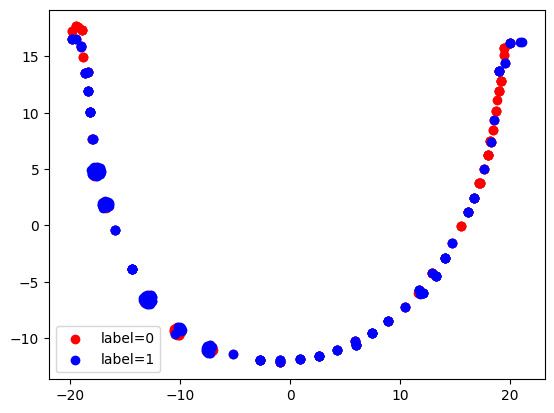

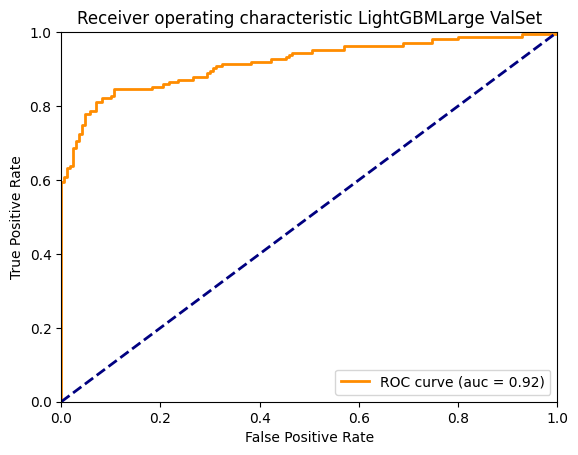

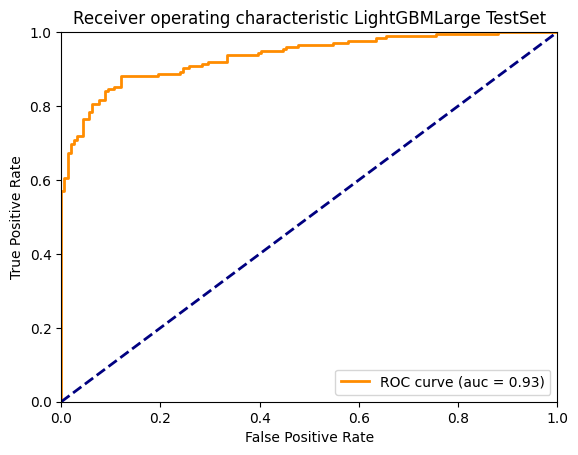

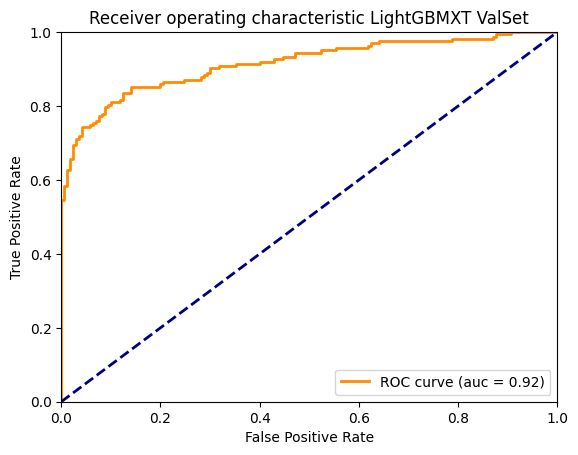

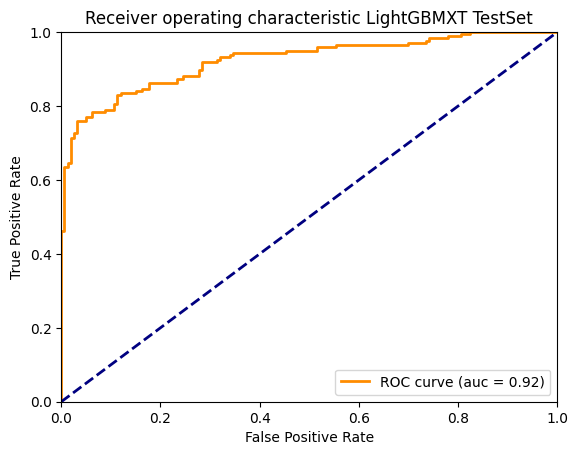

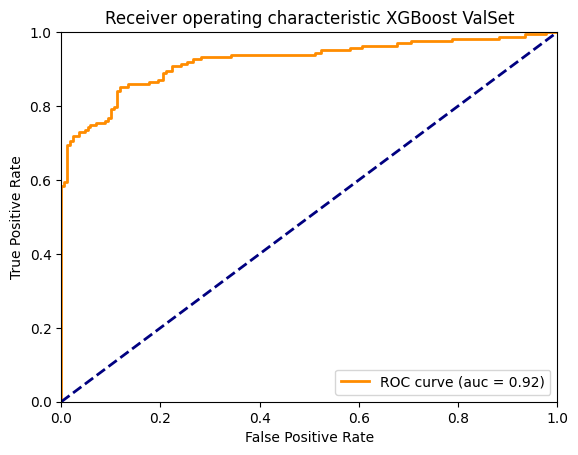

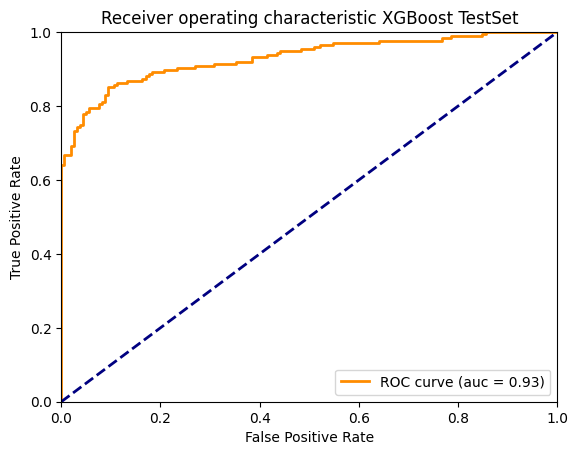

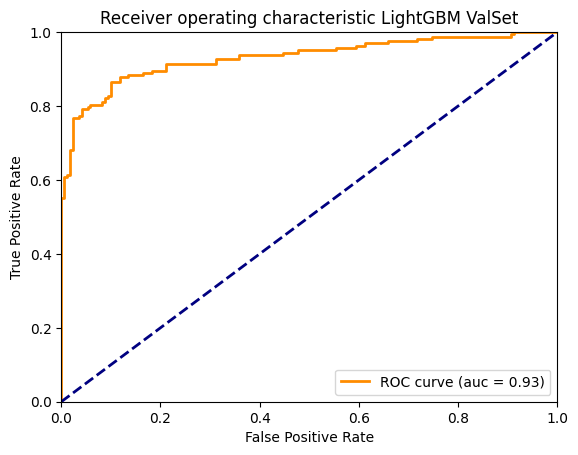

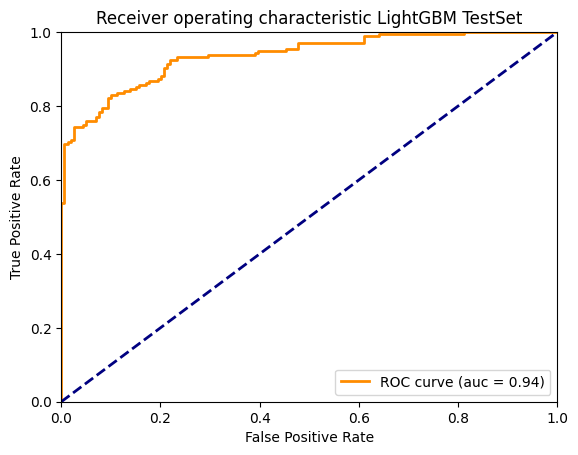

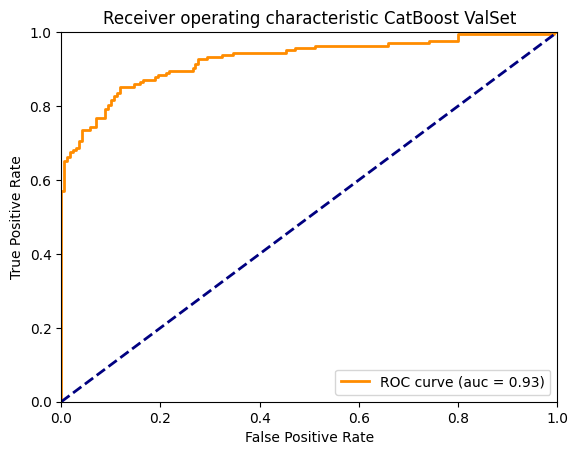

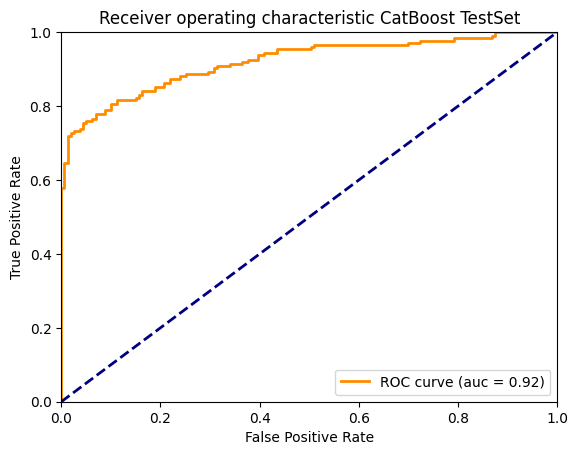

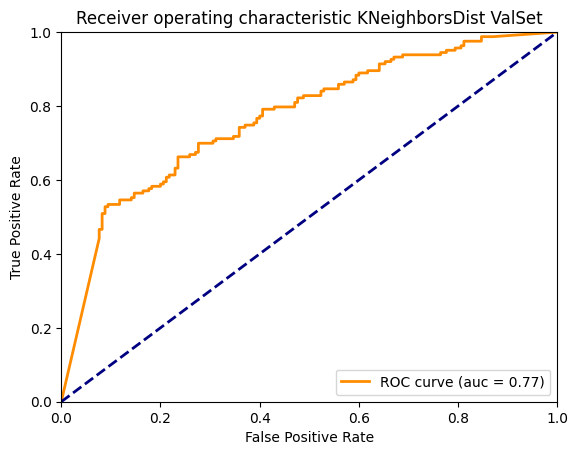

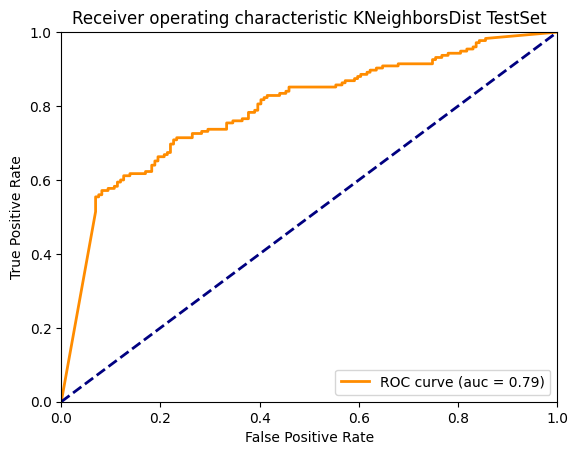

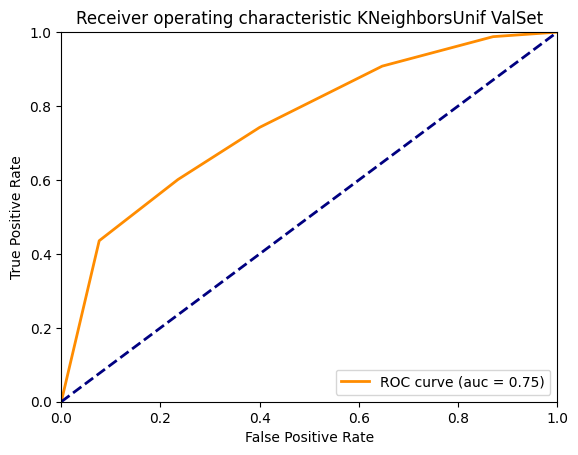

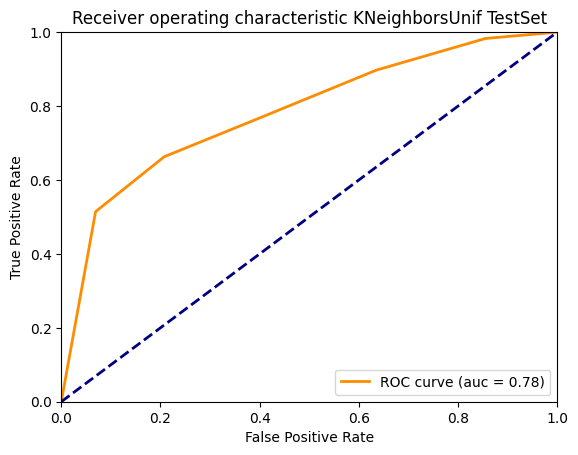

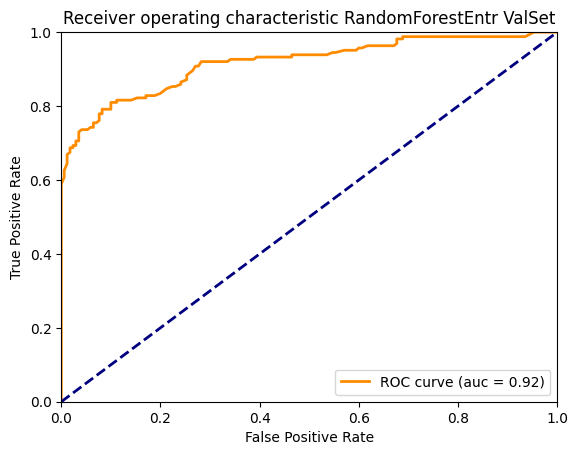

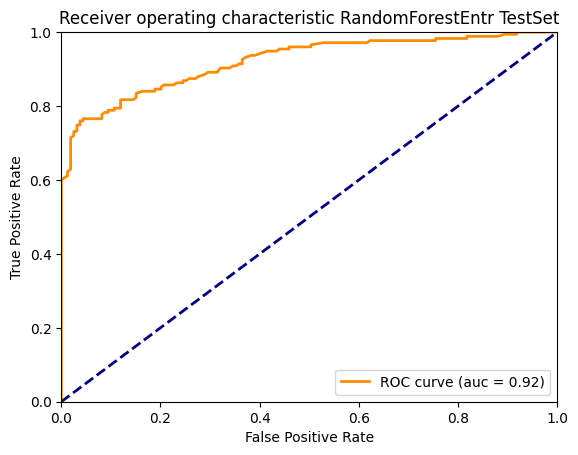

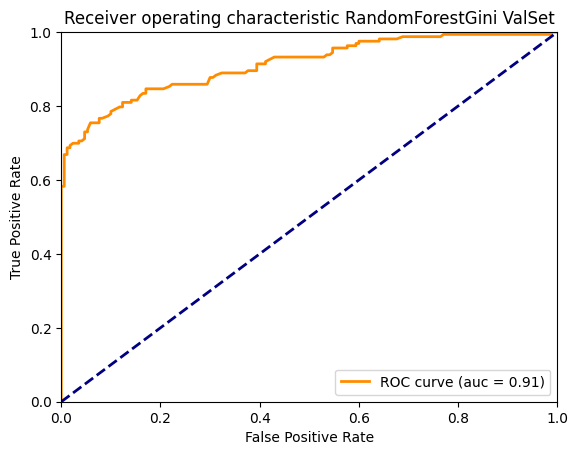

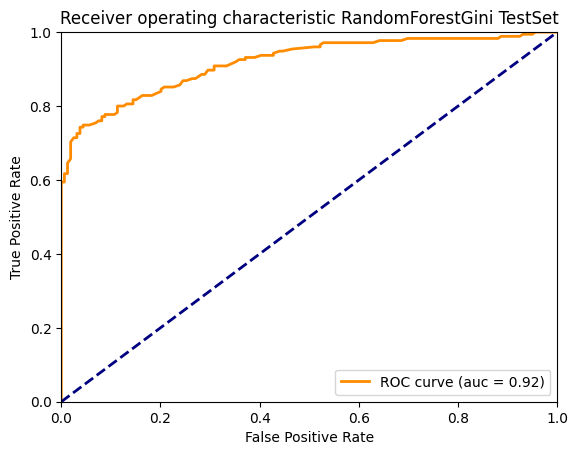

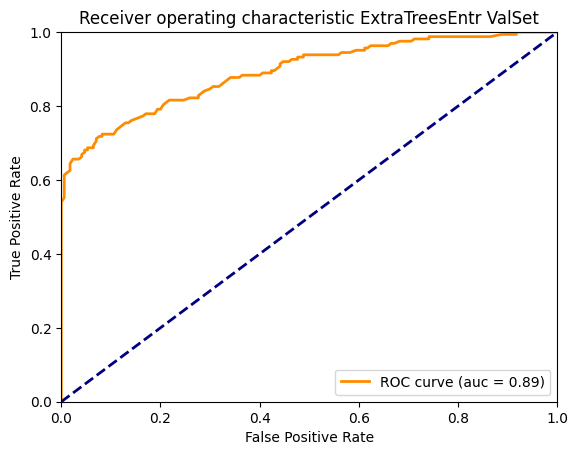

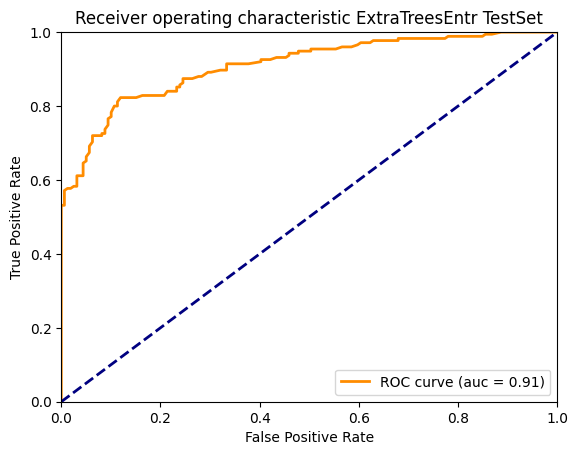

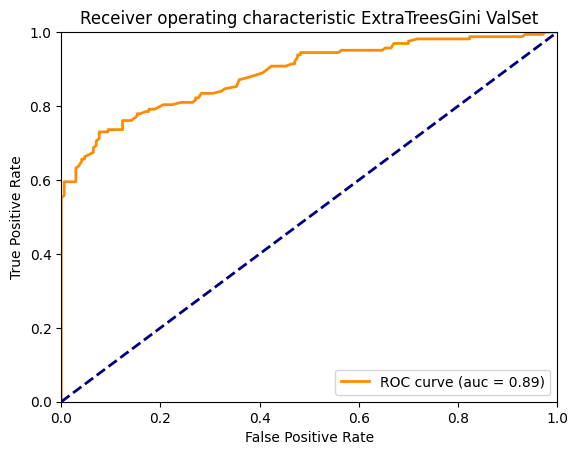

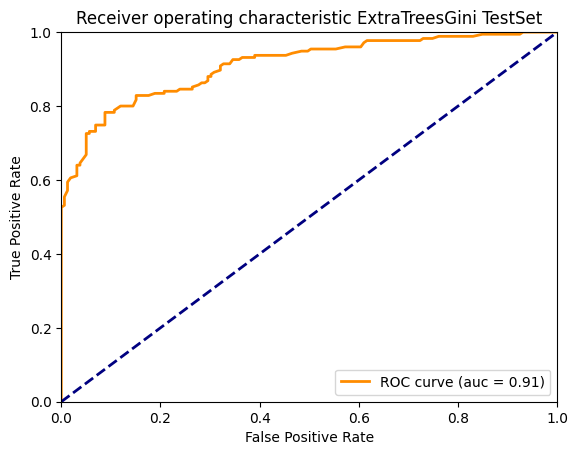

[0.         0.         0.         0.         0.         0.
 0.         0.         0.88288288 0.85329341]


In [7]:
# 转换为整数
finallist = list()
maxcount = 0
for value in dataset_origin['Value']:
    charlist = list()
    char_count = 0
    for char in value:
        charlist.append((ord(char.upper())-64) + char_count*1000)
        char_count = char_count + 1
        if maxcount<charlist.__len__():
            maxcount = charlist.__len__()
    finallist.append(charlist)
X = np.zeros((finallist.__len__(),maxcount))
for i in range(finallist.__len__()):
    X[i,0:finallist[i].__len__()] = finallist[i]
y = np.array(dataset_origin['Label'])
dataset_origin_int_position_encode = pd.DataFrame(np.hstack([X, np.expand_dims(y, -1)]))
print(dataset_origin_int_position_encode)
result_int_position_encode = access_dataset(dataset_origin_int_position_encode,'intPositionEncode',use_nlp=False)
print(result_int_position_encode)

In [23]:
 # 定义返回数组，依次为：
# 深度学习验证集bert-base-uncased网络原始准确率，深度学习测试集bert-base-uncased网络原始准确率，
# 机器学习验证集bert-base-uncased网络准确率，机器学习测试集bert-base-uncased网络准确率，
# 深度学习验证集m3e-base网络原始准确率，深度学习测试集m3e-base网络原始准确率，
# 机器学习验证集m3e-base网络准确率，机器学习测试集m3e-base网络准确率，
# 机器学习验证集原始编码准确率，机器学习测试集原始编码准确率

label = [
    'Int Encode With ML(LightGBM)',
    'Int-Position Encode With ML(LightGBM)',
    'Sentence Encode BERT',
    'Sentence Encode BERT With ML(CatBoost)',
    'Sentence Encode M3E',
    'Sentence Encode M3E With ML(KNeighbors)',
    'Word Encode BERT',
    'Word Encode BERT With ML(LightGBM)',
    'Word Encode M3E',
    'Word Encode M3E With ML(LightGBM)'
]

label_1 = ['Val Set','Test Set']
final_result = np.zeros((4*2+2,2))
final_result[0,:] = result_int_encode[-2:]
final_result[1,:] = result_int_position_encode[-2:]
final_result[2,:] = result_origin[0:2]
final_result[3,:] = result_origin[2:4]
final_result[4,:] = result_origin[4:6]
final_result[5,:] = result_origin[6:8]
final_result[6,:] = result_add_space[0:2]
final_result[7,:] = result_add_space[2:4]
final_result[8,:] = result_add_space[4:6]
final_result[9,:] = result_add_space[6:8]

final_result = pd.DataFrame(final_result,index=label,columns=label_1)
final_result.to_csv(os.path.join('outputFigure','finalResult.csv'))
final_result

Val Set  Test Set
Int Encode With ML(LightGBM)             0.882883  0.853293
Int-Position Encode With ML(LightGBM)    0.882883  0.853293
Sentence Encode BERT                     0.903904  0.904192
Sentence Encode BERT With ML(CatBoost)   0.900901  0.901198
Sentence Encode M3E                      0.903904  0.889222
Sentence Encode M3E With ML(KNeighbors)  0.906907  0.922156
Word Encode BERT                         0.909910  0.919162
Word Encode BERT With ML(LightGBM)       0.918919  0.907186
Word Encode M3E                          0.903904  0.940120
Word Encode M3E With ML(LightGBM)        0.924925  0.913174

In [39]:
final_nlp_predictor = MultiModalPredictor.load(path=os.path.join('outputFigure','addSpace','m3e-base','model','nlp'))
final_ml_predictor = TabularPredictor.load(path=os.path.join('outputFigure','addSpace','m3e-base','model','ml'))

predict_test_data = load_pd.load('./predict_test_data.csv')

predict_result = final_ml_predictor.predict(pd.DataFrame(final_nlp_predictor.extract_embedding(predict_test_data)),as_pandas=False,model='KNeighborsDist')
predict_result_proba = final_ml_predictor.predict_proba(pd.DataFrame(final_nlp_predictor.extract_embedding(predict_test_data)),as_pandas=False,model='KNeighborsDist')

label_2 = ['Seq','Result_m3e_KNeighborsDist','0 Proba','1 Proba']
predict_result = pd.DataFrame(np.hstack([np.expand_dims(predict_test_data.Value.to_numpy(copy=True), -1), np.expand_dims(np.squeeze(predict_result), -1), np.expand_dims(np.squeeze(predict_result_proba)[:,0], -1), np.expand_dims(np.squeeze(predict_result_proba)[:,1], -1)]),columns=label_2)

predict_result.to_csv(os.path.join('outputFigure','predictTestResultNLPML.csv'))
predict_result

Load pretrained checkpoint: /mnt/e/徐美琦项目/outputFigure/addSpace/m3e-base/model/nlp/model.ckpt
Loaded data from: ./predict_test_data.csv | Columns = 1 / 1 | Rows = 741 -> 741


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seq  \
0                              PEEMYTRTTCRAWQTWRMDWLVAWYLHYVCTEI   
1                                     CFVVWGWEQTRHKEAWVIAWHRDCDY   
2                          EVIGVFTIRSEQRFLAGTYCWKAPRHKESEAKARAER   
3                             RCMAMGQNANTEWIWDTHACEIHMDKKVVTMDRC   
4                                                      LNFSCHSNS   
..                                                           ...   
736                                          QVGLIAVCVEDAASFWYCM   
737                            ELPYRGIPIKVFKFDHKISRHGSAYWNEIWGAN   
738  VCVMPDYMVNWTPTYKNRFENKWMPHCSFEGIMCCQGGSRCSAHPMVVFARVWAEHMRN   
739                                 THPTEAYMQNKQRQQAMTVEYPCVRAID   
740                                              RFCFSQTGLTQMTVR   

    Result_m3e_KNeighborsDist   0 Proba   1 Proba  
0                         1.0  0.397384  0.602616  
1                         1.0       0.0       1.0  
2                         1.0       0.0       1.0  
3                         0.0  0.596049  0.403951  
4                         0.0       1.0       0.0  
..                        ...       ...       ...  
736                       0.0  0.598833  0.401167  
737                       1.0  0.197351  0.802649  
738                       0.0       1.0       0.0  
739                       1.0  0.407134  0.592866  
740                       1.0  0.405333  0.594667  

[741 rows x 4 columns]

In [41]:
predict_result = final_nlp_predictor.predict(predict_test_data,as_pandas=False)
predict_result_proba = final_nlp_predictor.predict_proba(predict_test_data,as_pandas=False)

label_2 = ['Seq','Result_m3e','0 Proba','1 Proba']
predict_result = pd.DataFrame(np.hstack([np.expand_dims(predict_test_data.Value.to_numpy(copy=True), -1), np.expand_dims(np.squeeze(predict_result), -1), np.expand_dims(np.squeeze(predict_result_proba)[:,0], -1), np.expand_dims(np.squeeze(predict_result_proba)[:,1], -1)]),columns=label_2)

predict_result.to_csv(os.path.join('outputFigure','predictTestResultNLP.csv'))
predict_result

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seq Result_m3e  \
0                              PEEMYTRTTCRAWQTWRMDWLVAWYLHYVCTEI          0   
1                                     CFVVWGWEQTRHKEAWVIAWHRDCDY          1   
2                          EVIGVFTIRSEQRFLAGTYCWKAPRHKESEAKARAER          1   
3                             RCMAMGQNANTEWIWDTHACEIHMDKKVVTMDRC          0   
4                                                      LNFSCHSNS          0   
..                                                           ...        ...   
736                                          QVGLIAVCVEDAASFWYCM          1   
737                            ELPYRGIPIKVFKFDHKISRHGSAYWNEIWGAN          1   
738  VCVMPDYMVNWTPTYKNRFENKWMPHCSFEGIMCCQGGSRCSAHPMVVFARVWAEHMRN          0   
739                                 THPTEAYMQNKQRQQAMTVEYPCVRAID          1   
740                                              RFCFSQTGLTQMTVR          0   

      0 Proba   1 Proba  
0    0.745769  0.254231  
1    0.309304  0.690696  
2    0.241288  0.758712  
3    0.654812  0.345188  
4    0.734215  0.265785  
..        ...       ...  
736  0.465699  0.534301  
737  0.155784  0.844216  
738  0.836421  0.163579  
739  0.336113  0.663887  
740  0.577786  0.422214  

[741 rows x 4 columns]